In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import warnings

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [3]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.credible_interval"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 11.1

In [4]:
d = pd.read_csv("Data/chimpanzees.csv", sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1
d

actor  recipient  condition  block  trial  prosoc_left  chose_prosoc  \
0        0        NaN          0      1      2            0             1   
1        0        NaN          0      1      4            0             0   
2        0        NaN          0      1      6            1             0   
3        0        NaN          0      1      8            0             1   
4        0        NaN          0      1     10            1             1   
..     ...        ...        ...    ...    ...          ...           ...   
499      6        4.0          1      6     64            1             1   
500      6        6.0          1      6     66            1             1   
501      6        3.0          1      6     68            0             0   
502      6        7.0          1      6     70            0             0   
503      6        2.0          1      6     72            0             0   

     pulled_left  
0              0  
1              1  
2              0  
3              0  
4              1  
..           ...  
499            1  
500            1  
501            1  
502            1  
503            1  

[504 rows x 8 columns]

#### Code 11.2

In [5]:
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]

actor  prosoc_left  condition  treatment
0        0            0          0          0
1        0            0          0          0
2        0            1          0          1
3        0            0          0          0
4        0            1          0          1
..     ...          ...        ...        ...
499      6            1          1          3
500      6            1          1          3
501      6            0          1          2
502      6            0          1          2
503      6            0          1          2

[504 rows x 4 columns]

#### Code 11.3

In [6]:
d.groupby("treatment").first()[["prosoc_left", "condition"]]

prosoc_left  condition
treatment                        
0                    0          0
1                    1          0
2                    0          1
3                    1          1

#### Code 11.4 and 11.5

In [7]:
with pm.Model() as m11_1:
    a = pm.Normal("a", 0.0, 10.0)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_1 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1 = az.from_pymc3(prior=prior_11_1)

# need it to recreate the prior pred plot:
with pm.Model() as m11_1bis:
    a = pm.Normal("a", 0.0, 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_1bis = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1bis = az.from_pymc3(prior=prior_11_1bis)

#### Code 11.6

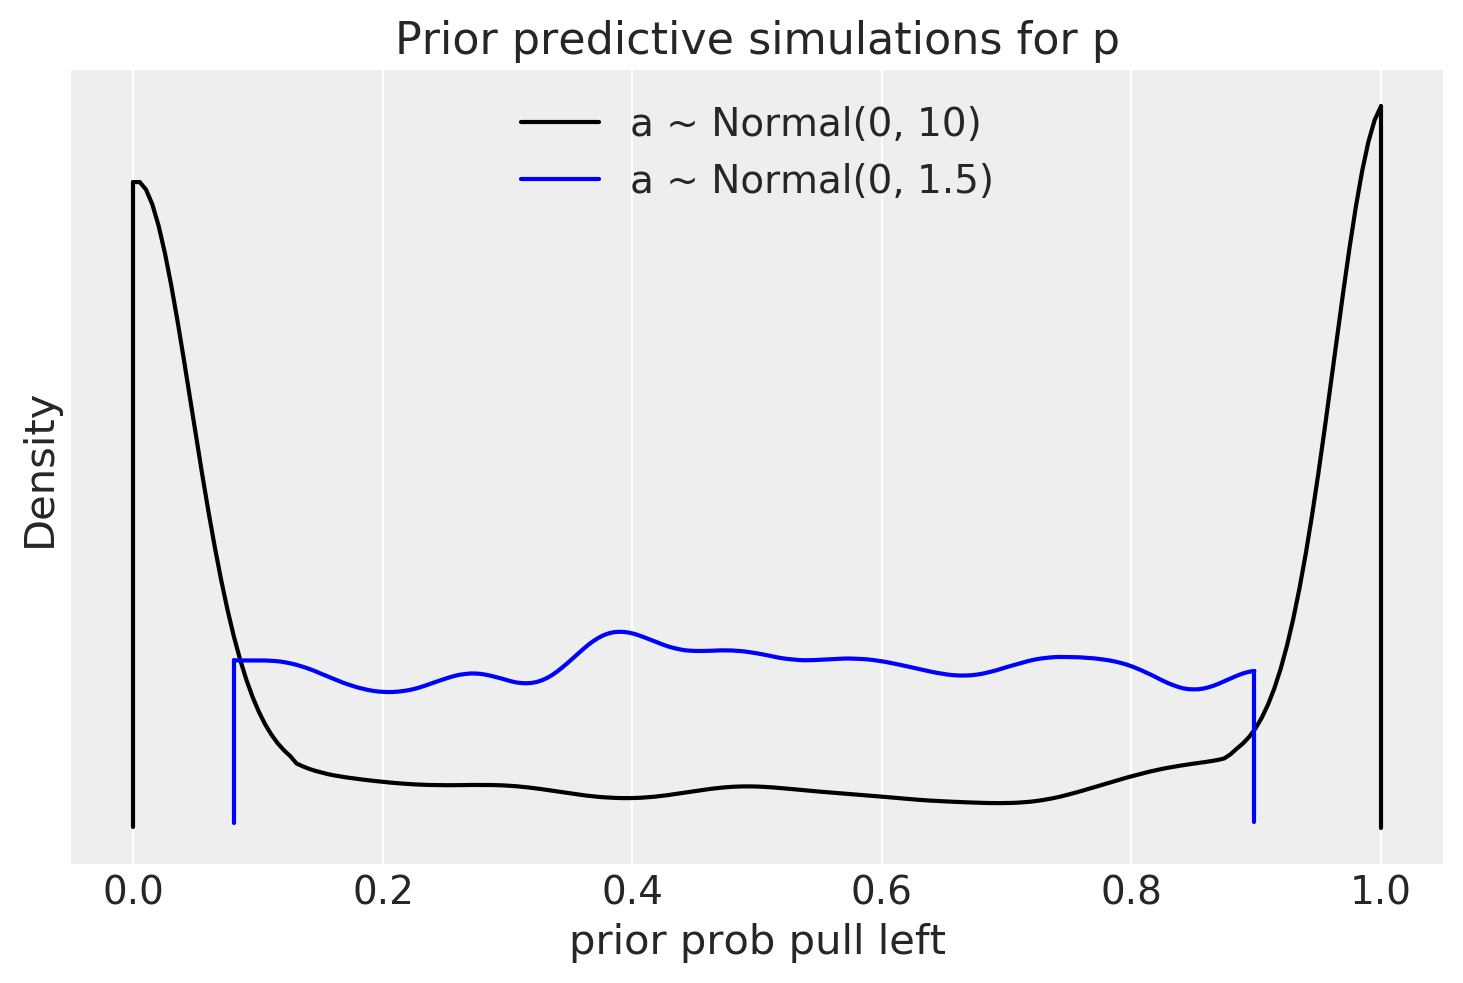

In [8]:
ax = az.plot_density(
    [idata_11_1, idata_11_1bis],
    data_labels=["a ~ Normal(0, 10)", "a ~ Normal(0, 1.5)"],
    group="prior",
    colors=["k", "b"],
    var_names=["p"],
    point_estimate=None,
)
ax[0].set_xlabel("prior prob pull left")
ax[0].set_ylabel("Density")
ax[0].set_title("Prior predictive simulations for p");

#### Code 11.7 - 11.9

In [9]:
with pm.Model() as m11_2:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 10.0, shape=4)

    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_2 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_2 = az.from_pymc3(prior=prior_11_2)
prior_2 = idata_11_2.prior

with pm.Model() as m11_3:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 0.5, shape=4)

    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_3 = az.from_pymc3(prior=prior_11_3)
prior_3 = idata_11_3.prior

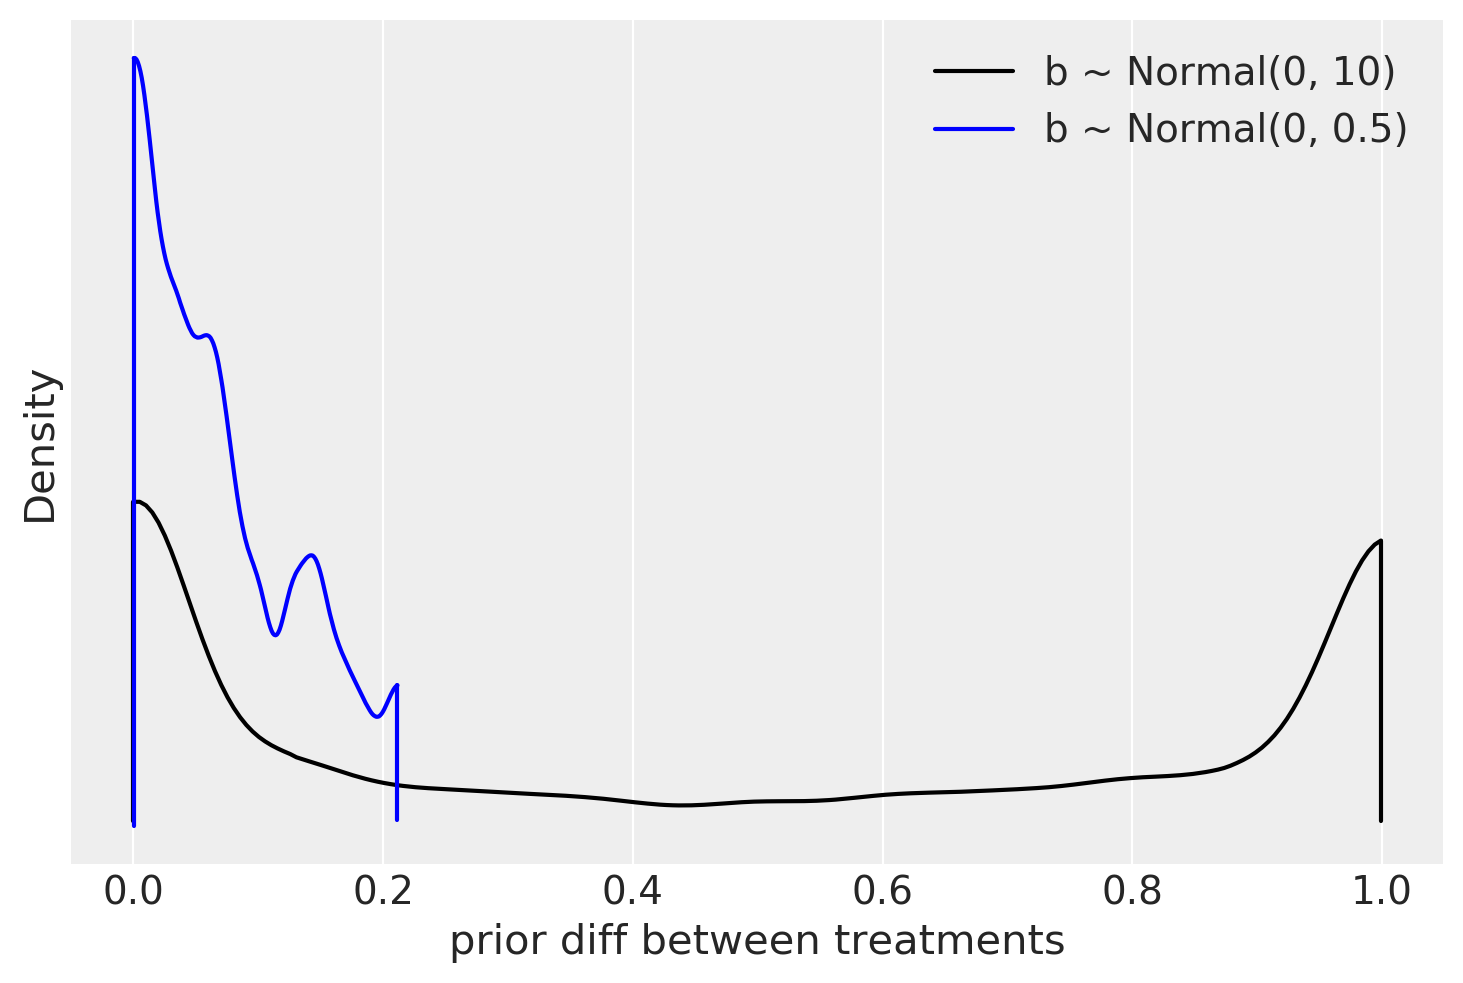

In [10]:
p_treat1, p_treat2 = (
    logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0=0)),
    logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0=1)),
)
p_treat1_bis, p_treat2_bis = (
    logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0=0)),
    logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0=1)),
)

ax = az.plot_density(
    [np.abs(p_treat1 - p_treat2).values, np.abs(p_treat1_bis - p_treat2_bis).values],
    data_labels=["b ~ Normal(0, 10)", "b ~ Normal(0, 0.5)"],
    group="prior",
    colors=["k", "b"],
    point_estimate=None,
)
ax[0].set_xlabel("prior diff between treatments")
ax[0].set_ylabel("Density")
ax[0].set_title(None);

In [11]:
np.abs(p_treat1_bis - p_treat2_bis).mean().values

array(0.09629389)

#### Code 11.10

In [12]:
actor_idx, actors = pd.factorize(d.actor)
treat_idx, treatments = pd.factorize(d.treatment)

#### Code 11.11

In [13]:
with pm.Model() as m11_4:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    b = pm.Normal("b", 0.0, 0.5, shape=len(treatments))

    actor_id = pm.intX(pm.Data("actor_id", actor_idx))
    treat_id = pm.intX(pm.Data("treat_id", treat_idx))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_id] + b[treat_id]))

    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_11_4 = pm.sample(random_seed=RANDOM_SEED)
idata_11_4 = az.from_pymc3(trace_11_4)
az.summary(idata_11_4, var_names=["a", "b"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a[0] -0.44  0.34     -0.97       0.11       0.01     0.01   1464.87  1464.87   
a[1]  3.88  0.74      2.71       5.01       0.01     0.01   3472.49  3250.05   
a[2] -0.74  0.34     -1.29      -0.22       0.01     0.01   1460.16  1460.16   
a[3] -0.75  0.34     -1.27      -0.21       0.01     0.01   1460.62  1460.62   
a[4] -0.45  0.33     -0.98       0.07       0.01     0.01   1397.71  1397.71   
a[5]  0.48  0.34     -0.08       0.99       0.01     0.01   1584.14  1584.14   
a[6]  1.96  0.43      1.33       2.68       0.01     0.01   2041.10  2041.10   
b[0] -0.04  0.29     -0.48       0.43       0.01     0.01   1453.45  1453.45   
b[1]  0.48  0.29      0.00       0.93       0.01     0.01   1424.96  1424.96   
b[2] -0.39  0.29     -0.83       0.08       0.01     0.01   1338.31  1338.31   
b[3]  0.37  0.29     -0.09       0.82       0.01     0.01   1255.96  1241.95   

      ess_bulk  ess_tail  r_hat  
a[0]   1465.74   2151.23    1.0  
a[1]   3578.74   2358.92    1.0  
a[2]   1459.51   2380.71    1.0  
a[3]   1471.17   2488.63    1.0  
a[4]   1400.03   2084.99    1.0  
a[5]   1587.05   2402.70    1.0  
a[6]   2041.38   2622.59    1.0  
b[0]   1456.37   2309.17    1.0  
b[1]   1432.56   2404.44    1.0  
b[2]   1342.59   1889.29    1.0  
b[3]   1263.45   2102.32    1.0

#### Code 11.12

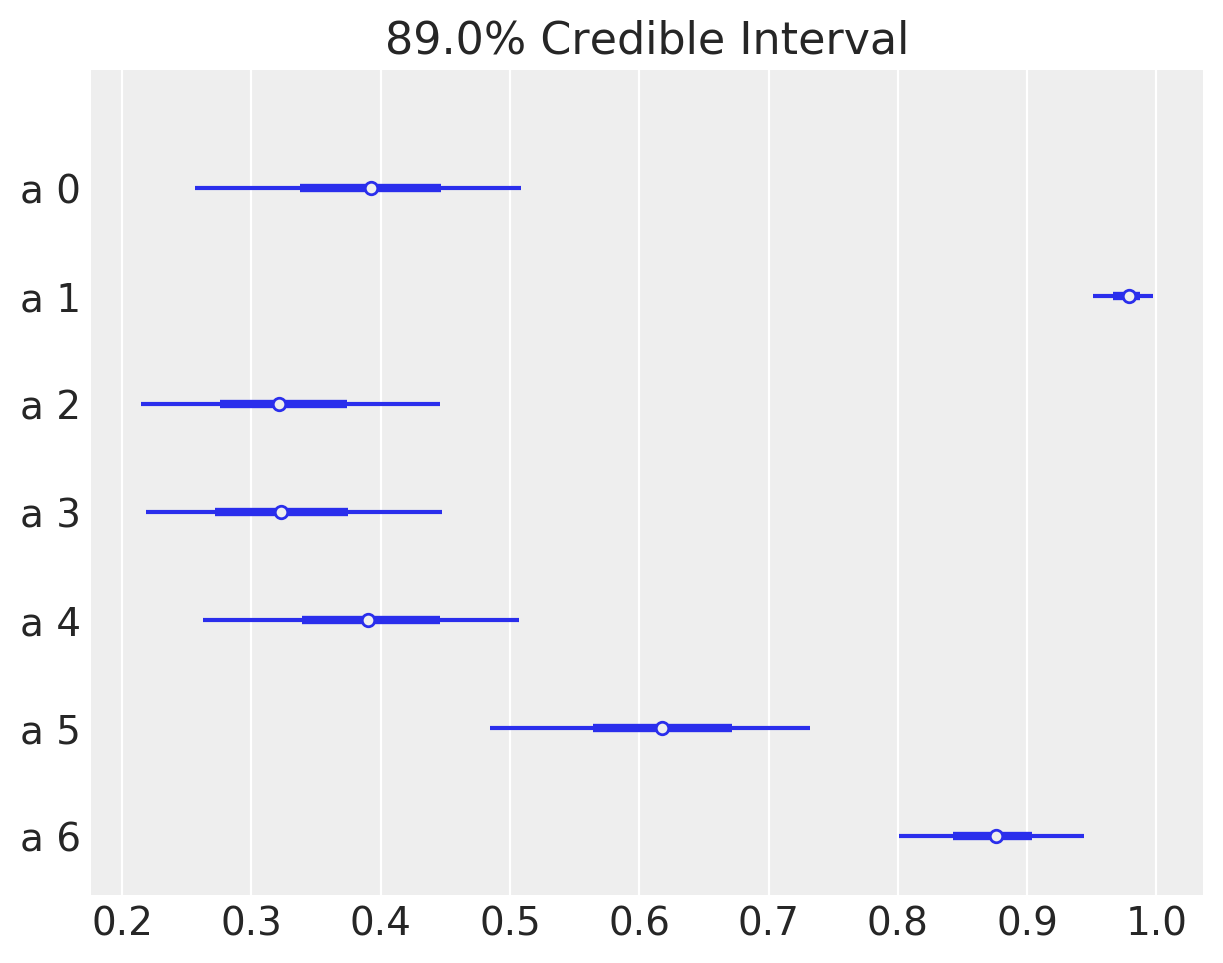

In [14]:
az.plot_forest(idata_11_4, var_names=["a"], transform=logistic, combined=True);

#### Code 11.13

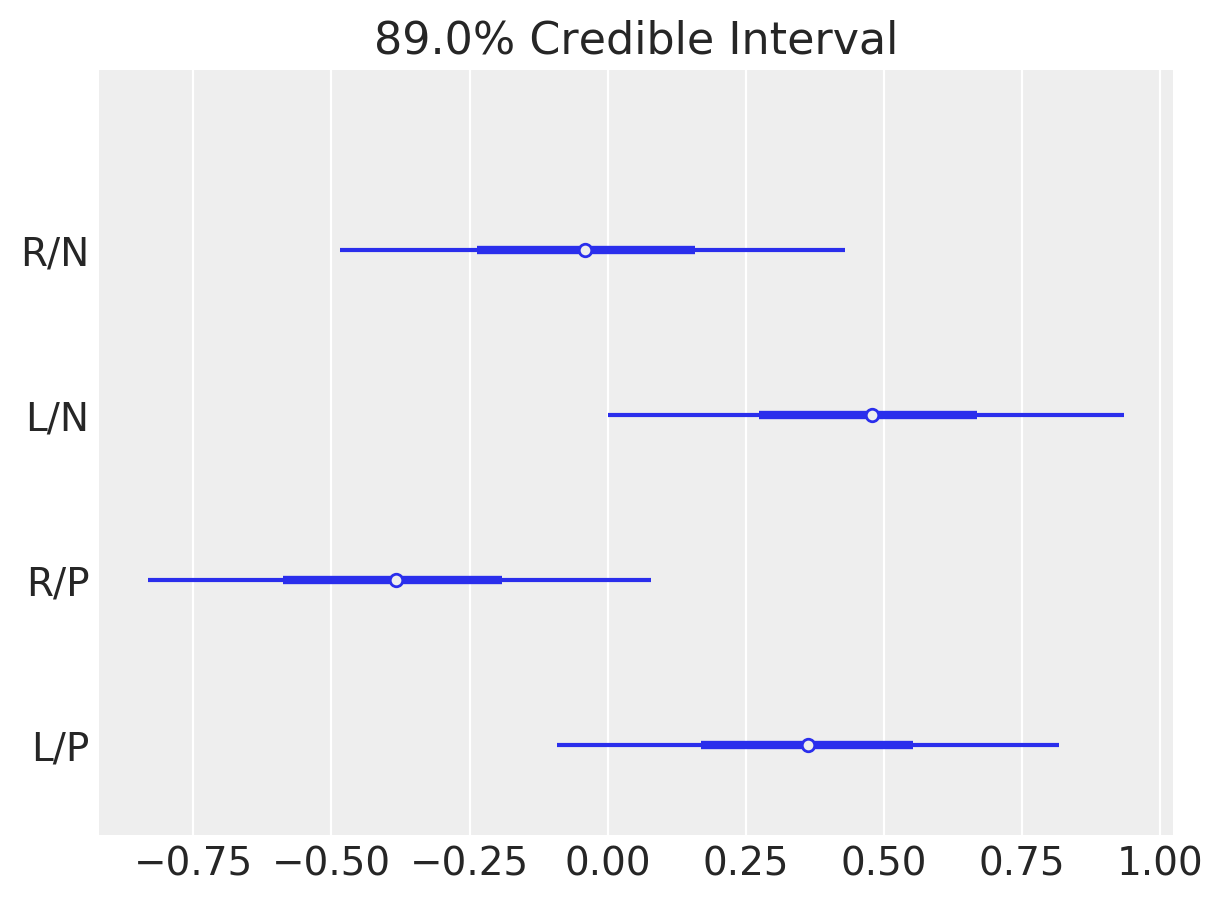

In [15]:
ax = az.plot_forest(idata_11_4, var_names=["b"], combined=True)
ax[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);

#### Code 11.14

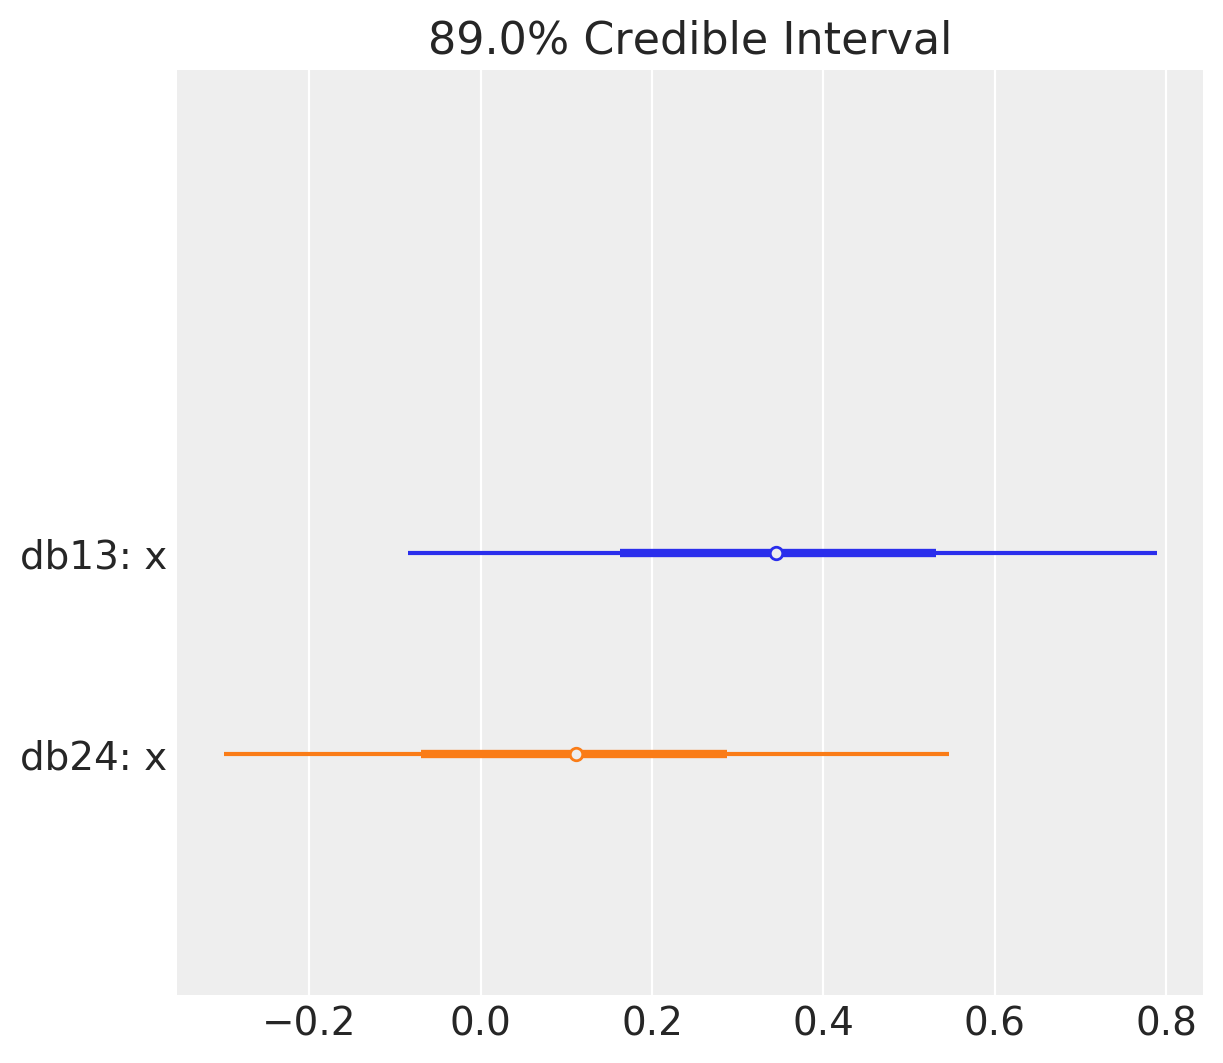

In [16]:
db13 = idata_11_4.posterior["b"].sel(b_dim_0=0) - idata_11_4.posterior["b"].sel(
    b_dim_0=2
)
db24 = idata_11_4.posterior["b"].sel(b_dim_0=1) - idata_11_4.posterior["b"].sel(
    b_dim_0=3
)
az.plot_forest([db13.values, db24.values], model_names=["db13", "db24"], combined=True);

#### Code 11.15

In [17]:
pl = d.groupby(["actor", "treatment"]).agg("mean")["pulled_left"].unstack()
pl

treatment         0         1         2         3
actor                                            
0          0.333333  0.500000  0.277778  0.555556
1          1.000000  1.000000  1.000000  1.000000
2          0.277778  0.611111  0.166667  0.333333
3          0.333333  0.500000  0.111111  0.444444
4          0.333333  0.555556  0.277778  0.500000
5          0.777778  0.611111  0.555556  0.611111
6          0.777778  0.833333  0.944444  1.000000

#### Code 11.16 and 11.17

In [18]:
with m11_4:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4)) * 7})
    p_post = pm.sample_posterior_predictive(
        trace_11_4, random_seed=RANDOM_SEED, var_names=["p"]
    )["p"]
p_mu = p_post.mean(0).reshape((7, 4))

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (28). Passed array should have shape (chains, draws, *shape)
  UserWarning,


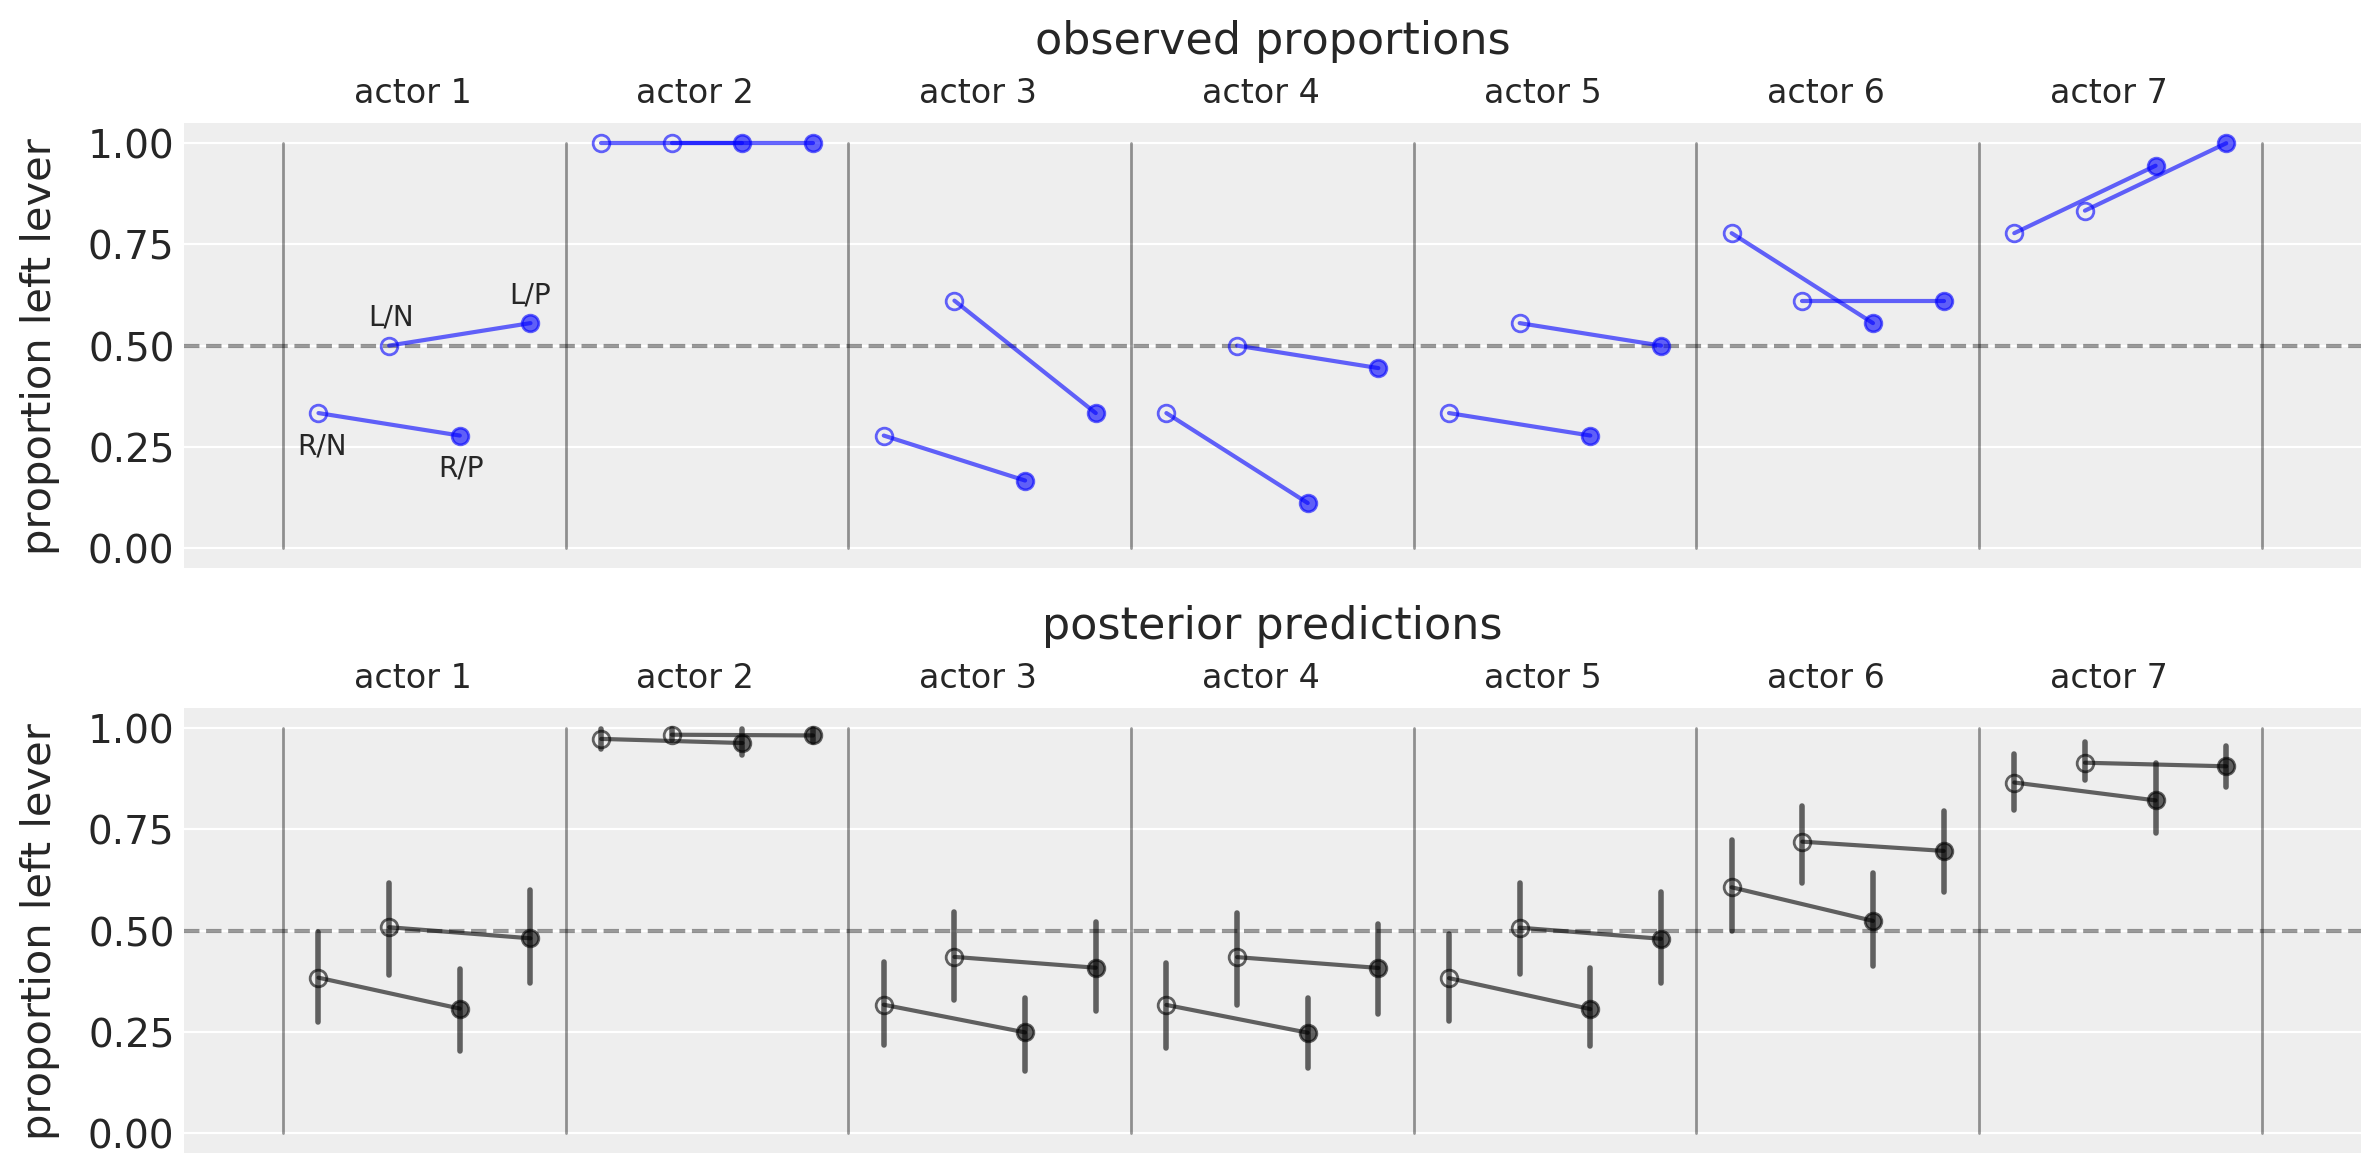

In [19]:
pl_val = pl.stack().values
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
alpha, xoff, yoff = 0.6, 0.3, 0.05

ax0.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax0.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax0.plot(
        [actor * 4, actor * 4 + 2],
        [pl.loc[actor, 0], pl.loc[actor, 2]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [pl.loc[actor, 1], pl.loc[actor, 3]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4, actor * 4 + 1],
        [pl.loc[actor, 0], pl.loc[actor, 1]],
        "o",
        c="b",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [pl.loc[actor, 2], pl.loc[actor, 3]],
        "o",
        c="b",
        ms=6,
        alpha=alpha,
    )
    ax0.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax0.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
    if actor == 0:
        ax0.text(actor * 4 - xoff, pl.loc[actor, 0] - 2 * yoff, "R/N")
        ax0.text(actor * 4 + 1 - xoff, pl.loc[actor, 1] + yoff, "L/N")
        ax0.text(actor * 4 + 2 - xoff, pl.loc[actor, 2] - 2 * yoff, "R/P")
        ax0.text(actor * 4 + 3 - xoff, pl.loc[actor, 3] + yoff, "L/P")
ax0.set_xticks([])
ax0.set_ylabel("proportion left lever", labelpad=10)
ax0.set_title("observed proportions", pad=25)

ax1.plot([range(28), range(28)], az.hpd(p_post).T, "k-", lw=2, alpha=alpha)
ax1.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax1.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax1.plot(
        [actor * 4, actor * 4 + 2],
        [p_mu[actor, 0], p_mu[actor, 2]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [p_mu[actor, 1], p_mu[actor, 3]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4, actor * 4 + 1],
        [p_mu[actor, 0], p_mu[actor, 1]],
        "o",
        c="k",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [p_mu[actor, 2], p_mu[actor, 3]],
        "o",
        c="k",
        ms=6,
        alpha=alpha,
    )
    ax1.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax1.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
ax1.set_xticks([])
ax1.set_ylabel("proportion left lever", labelpad=10)
ax1.set_title("posterior predictions", pad=25)
plt.tight_layout();

#### Code 11.18

In [20]:
side = d.prosoc_left.values  # right 0, left 1
cond = d.condition.values  # no partner 0, partner 1

#### Code 11.19

In [21]:
with pm.Model() as m11_5:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    bs = pm.Normal("bs", 0.0, 0.5, shape=2)
    bc = pm.Normal("bc", 0.0, 0.5, shape=2)

    p = pm.math.invlogit(a[actor_idx] + bs[side] + bc[cond])

    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_11_5 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bc, bs, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


#### Code 11.20
As we changed the data of `m11_4` above, we need to sample from it again, with the original data:

In [22]:
with m11_4:
    pm.set_data({"actor_id": actor_idx, "treat_id": treat_idx})
    trace_11_4 = pm.sample(random_seed=RANDOM_SEED)

az.compare({"m11_4": trace_11_4, "m11_5": trace_11_5})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


rank      loo    p_loo     d_loo    weight       se       dse warning  \
m11_5    0 -265.314  7.66349         0  0.660829  9.48123         0   False   
m11_4    1 -266.015  8.36606  0.700343  0.339171  9.57285  0.642995   False   

      loo_scale  
m11_5       log  
m11_4       log

#### Code 11.23

In [23]:
np.exp(trace_11_4["b"][:, 3] - trace_11_4["b"][:, 1]).mean().round(3)

0.926

#### Code 11.24

In [24]:
d = pd.read_csv("Data/chimpanzees.csv", sep=";")
d.actor = d.actor - 1
d["treatment"] = d.prosoc_left + 2 * d.condition

d_aggregated = (
    d.groupby(["treatment", "actor"])
    .sum()
    .reset_index()[["treatment", "actor", "pulled_left"]]
)
d_aggregated.head(10)

treatment  actor  pulled_left
0          0      0            6
1          0      1           18
2          0      2            5
3          0      3            6
4          0      4            6
5          0      5           14
6          0      6           14
7          1      0            9
8          1      1           18
9          1      2           11

#### Code 11.25

In [25]:
with pm.Model() as m11_6:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    b = pm.Normal("b", 0.0, 0.5, shape=len(treatments))

    p = pm.Deterministic(
        "p", pm.math.invlogit(a[d_aggregated.actor] + b[d_aggregated.treatment])
    )

    pulled_left = pm.Binomial("pulled_left", 18, p, observed=d_aggregated.pulled_left)

    trace_11_6 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


#### Code 11.26
ArviZ won't even let you compare models with different observations:

In [26]:
az.compare({"m11_4": trace_11_4, "m11_6": trace_11_6})

ValueError: The number of observations should be the same across all models

#### Code 11.27

In [28]:
# deviance of aggregated 6-in-9
(-2 * stats.binom.logpmf(6, 9, 0.2)).round(5)

11.79048

In [29]:
# deviance of dis-aggregated
-2 * stats.bernoulli.logpmf([1, 1, 1, 1, 1, 1, 0, 0, 0], 0.2).sum().round(5)

20.65212

#### Code 11.28

In [30]:
d_ad = pd.read_csv("Data/UCBadmit.csv", sep=";")
d_ad

dept applicant.gender  admit  reject  applications
1     A             male    512     313           825
2     A           female     89      19           108
3     B             male    353     207           560
4     B           female     17       8            25
5     C             male    120     205           325
6     C           female    202     391           593
7     D             male    138     279           417
8     D           female    131     244           375
9     E             male     53     138           191
10    E           female     94     299           393
11    F             male     22     351           373
12    F           female     24     317           341

#### Code 11.29

In [31]:
gid = (d_ad["applicant.gender"] == "female").astype(int).values

with pm.Model() as m11_7:
    a = pm.Normal("a", 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))

    admit = pm.Binomial("admit", p=p, n=d_ad.applications, observed=d_ad.admit)

    trace_11_7 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_11_7, var_names=["a"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a[0] -0.22  0.04     -0.29      -0.16        0.0      0.0   3730.06  3696.99   
a[1] -0.83  0.05     -0.91      -0.75        0.0      0.0   3842.32  3819.91   

      ess_bulk  ess_tail  r_hat  
a[0]   3727.33   2901.56    1.0  
a[1]   3851.43   2833.17    1.0

#### Code 11.30

In [32]:
diff_a = trace_11_7["a"][:, 0] - trace_11_7["a"][:, 1]
diff_p = logistic(trace_11_7["a"][:, 0]) - logistic(trace_11_7["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

mean    sd  hpd_5.5%  hpd_94.5%
diff_a  0.61  0.07      0.51       0.72
diff_p  0.14  0.02      0.12       0.17

#### Code 11.31

In [33]:
with m11_7:
    ppc = pm.sample_posterior_predictive(
        trace_11_7, random_seed=RANDOM_SEED, var_names=["admit"]
    )["admit"]
pp_admit = ppc / d_ad.applications.values[None, :]

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (12). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (12). Passed array should have shape (chains, draws, *shape)
  UserWarning,


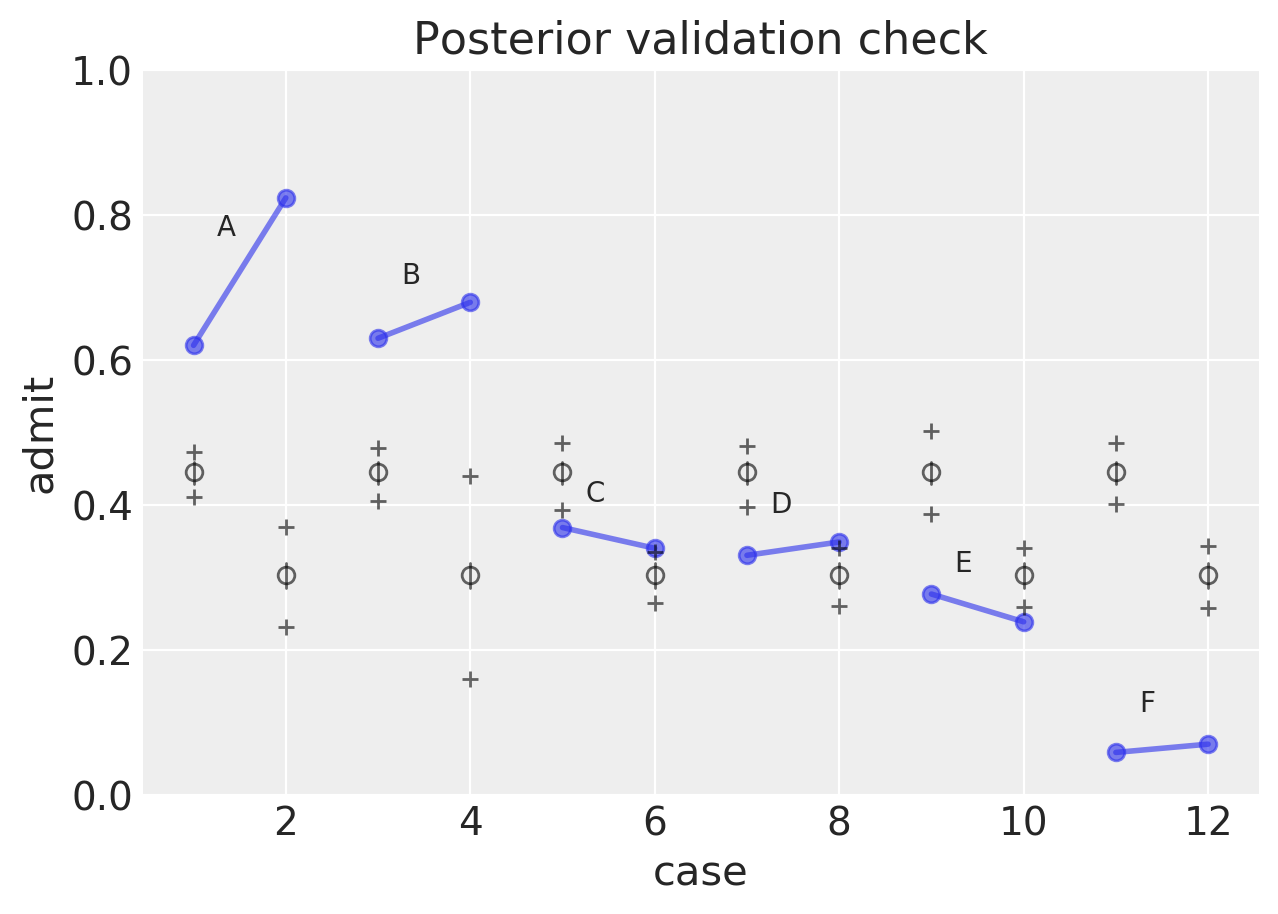

In [34]:
for i in range(6):
    x = 1 + 2 * i

    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x + 1] / d_ad.applications[x + 1]

    plt.plot([x, x + 1], [y1, y2], "-C0o", alpha=0.6, lw=2)
    plt.text(x + 0.25, (y1 + y2) / 2 + 0.05, d_ad.dept[x])

plt.plot(range(1, 13), trace_11_7["p"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(trace_11_7["p"]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(pp_admit).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(0, 1);

#### Code 11.32

In [35]:
dept_id = pd.Categorical(d_ad["dept"]).codes

with pm.Model() as m11_8:
    a = pm.Normal("a", 0, 1.5, shape=2)
    delta = pm.Normal("delta", 0, 1.5, shape=6)

    p = pm.math.invlogit(a[gid] + delta[dept_id])

    admit = pm.Binomial("admit", p=p, n=d_ad.applications, observed=d_ad.admit)

    trace_11_8 = pm.sample(2000, random_seed=RANDOM_SEED)
az.summary(trace_11_8, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
The number of effective samples is smaller than 10% for some parameters.


mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean  \
a[0]     -0.55  0.54     -1.34       0.39       0.02     0.02    521.93   
a[1]     -0.45  0.54     -1.33       0.41       0.02     0.02    519.19   
delta[0]  1.13  0.54      0.21       1.93       0.02     0.02    529.46   
delta[1]  1.08  0.54      0.18       1.93       0.02     0.02    523.72   
delta[2] -0.13  0.54     -1.07       0.66       0.02     0.02    521.77   
delta[3] -0.16  0.54     -1.08       0.66       0.02     0.02    520.11   
delta[4] -0.61  0.54     -1.45       0.29       0.02     0.02    537.26   
delta[5] -2.16  0.55     -3.08      -1.32       0.02     0.02    551.08   

          ess_sd  ess_bulk  ess_tail  r_hat  
a[0]      456.56    524.07    605.16   1.01  
a[1]      452.48    520.71    609.12   1.01  
delta[0]  488.89    530.49    640.06   1.01  
delta[1]  476.60    525.49    679.83   1.01  
delta[2]  521.77    521.65    696.15   1.01  
delta[3]  520.11    521.38    628.41   1.01  
delta[4]  537.26    540.66    578.97   1.01  
delta[5]  551.08    552.22    739.57   1.01

#### Code 11.33

In [36]:
diff_a = trace_11_8["a"][:, 0] - trace_11_8["a"][:, 1]
diff_p = logistic(trace_11_8["a"][:, 0]) - logistic(trace_11_8["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

mean    sd  hpd_5.5%  hpd_94.5%
diff_a -0.10  0.08     -0.23       0.03
diff_p -0.02  0.02     -0.05       0.01

#### Code 11.34

In [37]:
pg = pd.DataFrame(index=["male", "female"], columns=d_ad.dept.unique())
for dep in pg.columns:
    pg[dep] = (
        d_ad.loc[d_ad.dept == dep, "applications"]
        / d_ad.loc[d_ad.dept == dep, "applications"].sum()
    ).values
pg.round(2)

A     B     C     D     E     F
male    0.88  0.96  0.35  0.53  0.33  0.52
female  0.12  0.04  0.65  0.47  0.67  0.48

#### Code 11.35

In [38]:
y = np.random.binomial(n=1000, p=1 / 1000, size=10_000)
y.mean(), y.var()

(1.0022, 1.0089951599999998)

#### Code 11.36

In [39]:
dk = pd.read_csv("Data/Kline", sep=";")
dk

culture  population contact  total_tools  mean_TU
0    Malekula        1100     low           13      3.2
1     Tikopia        1500     low           22      4.7
2  Santa Cruz        3600     low           24      4.0
3         Yap        4791    high           43      5.0
4    Lau Fiji        7400    high           33      5.0
5   Trobriand        8000    high           19      4.0
6       Chuuk        9200    high           40      3.8
7       Manus       13000     low           28      6.6
8       Tonga       17500    high           55      5.4
9      Hawaii      275000     low           71      6.6

#### Code 11.37

In [40]:
P = standardize(np.log(dk.population)).values
c_id = (dk.contact == "high").astype(int).values

#### Code 11.38

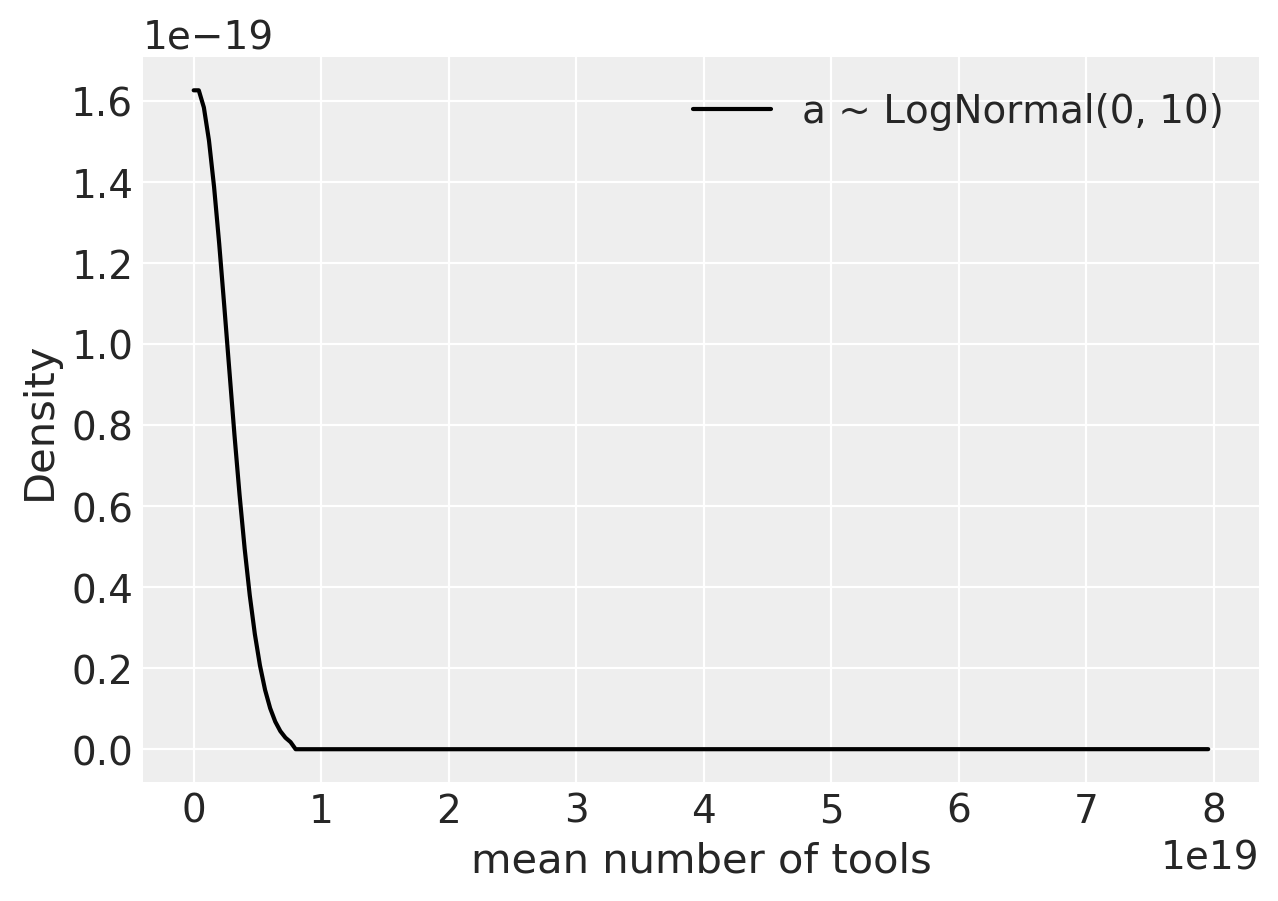

In [41]:
ax = az.plot_kde(
    pm.Lognormal.dist(0.0, 10.0).random(size=20_000),
    label="a ~ LogNormal(0, 10)",
    plot_kwargs={"color": "k"},
)
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

#### Code 11.39

In [42]:
a = np.random.normal(0.0, 10.0, size=10_000)
np.exp(a).mean()

254436047470334.78

#### Code 11.40

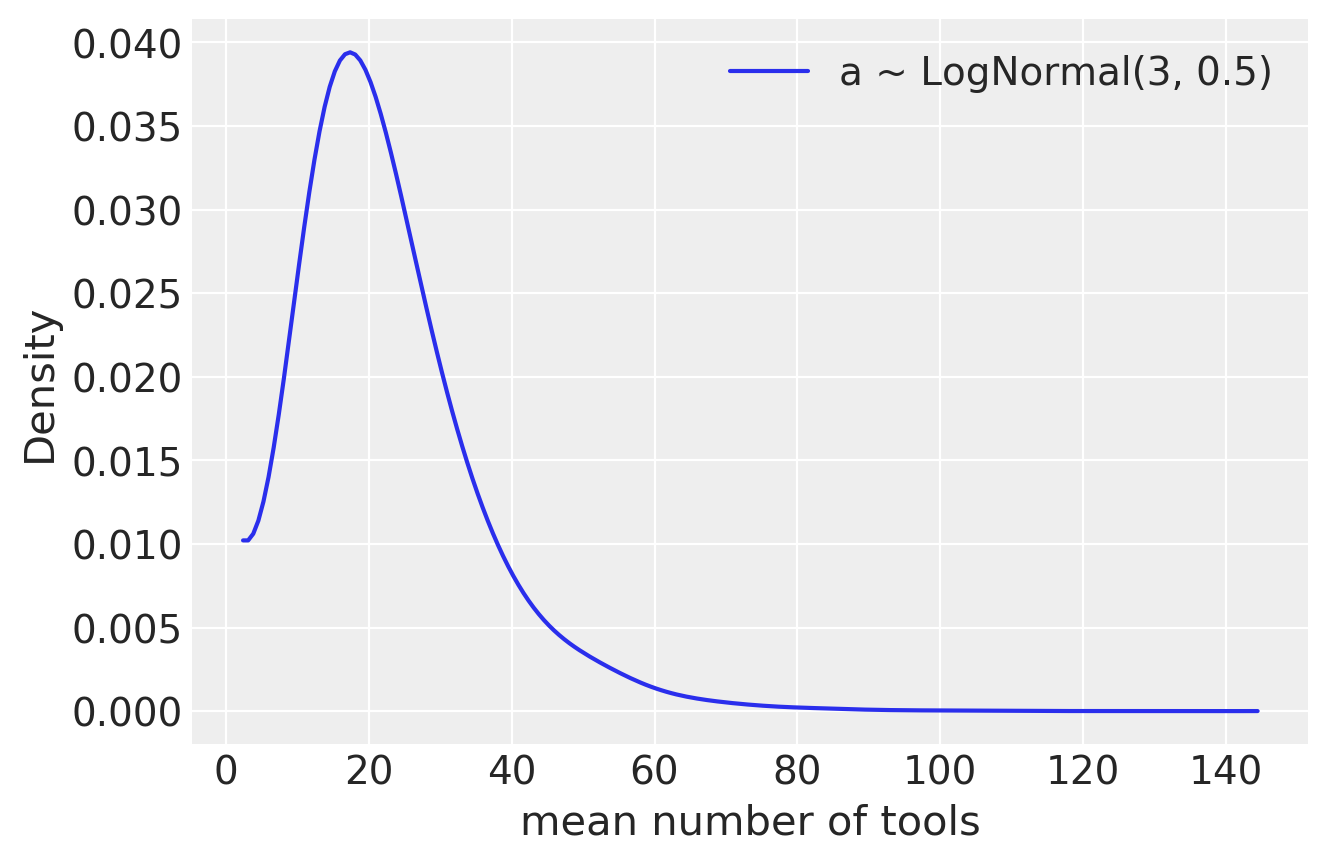

In [43]:
ax = az.plot_kde(
    pm.Lognormal.dist(3.0, 0.5).random(size=20_000), label="a ~ LogNormal(3, 0.5)"
)
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

#### Code 11.41 to 11.44

In [44]:
def kline_prior_plot(
    N: int = 100, b_prior: str = "bespoke", x_scale: str = "stdz", ax=None
):
    """
    Utility function to plot prior predictive checks for Kline Poisson model.
    N: number of prior predictive trends.
    
    """
    if ax is None:
        _, ax = plt.subplots()
    ax.set_ylabel("total tools")

    itcpts = np.random.normal(3.0, 0.5, N)
    if b_prior == "conventional":
        slopes = np.random.normal(0.0, 10.0, N)
        ax.set_title("b ~ Normal(0, 10)")
    elif b_prior == "bespoke":
        slopes = np.random.normal(0.0, 0.2, N)
        ax.set_title("b ~ Normal(0, 0.2)")
    else:
        raise ValueError(
            "Prior for slopes (b_prior) can only be either 'conventional' or 'bespoke'."
        )

    x_seq = np.linspace(np.log(100), np.log(200_000), N)
    ax.set_ylim((0, 500))
    if x_scale == "log":
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("log population")
    elif x_scale == "natural":
        for a, b in zip(itcpts, slopes):
            ax.plot(np.exp(x_seq), np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("population")
    else:
        x_seq = np.linspace(-2, 2, N)
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_ylim((0, 100))
        ax.set_xlabel("log population (std)")

    return ax

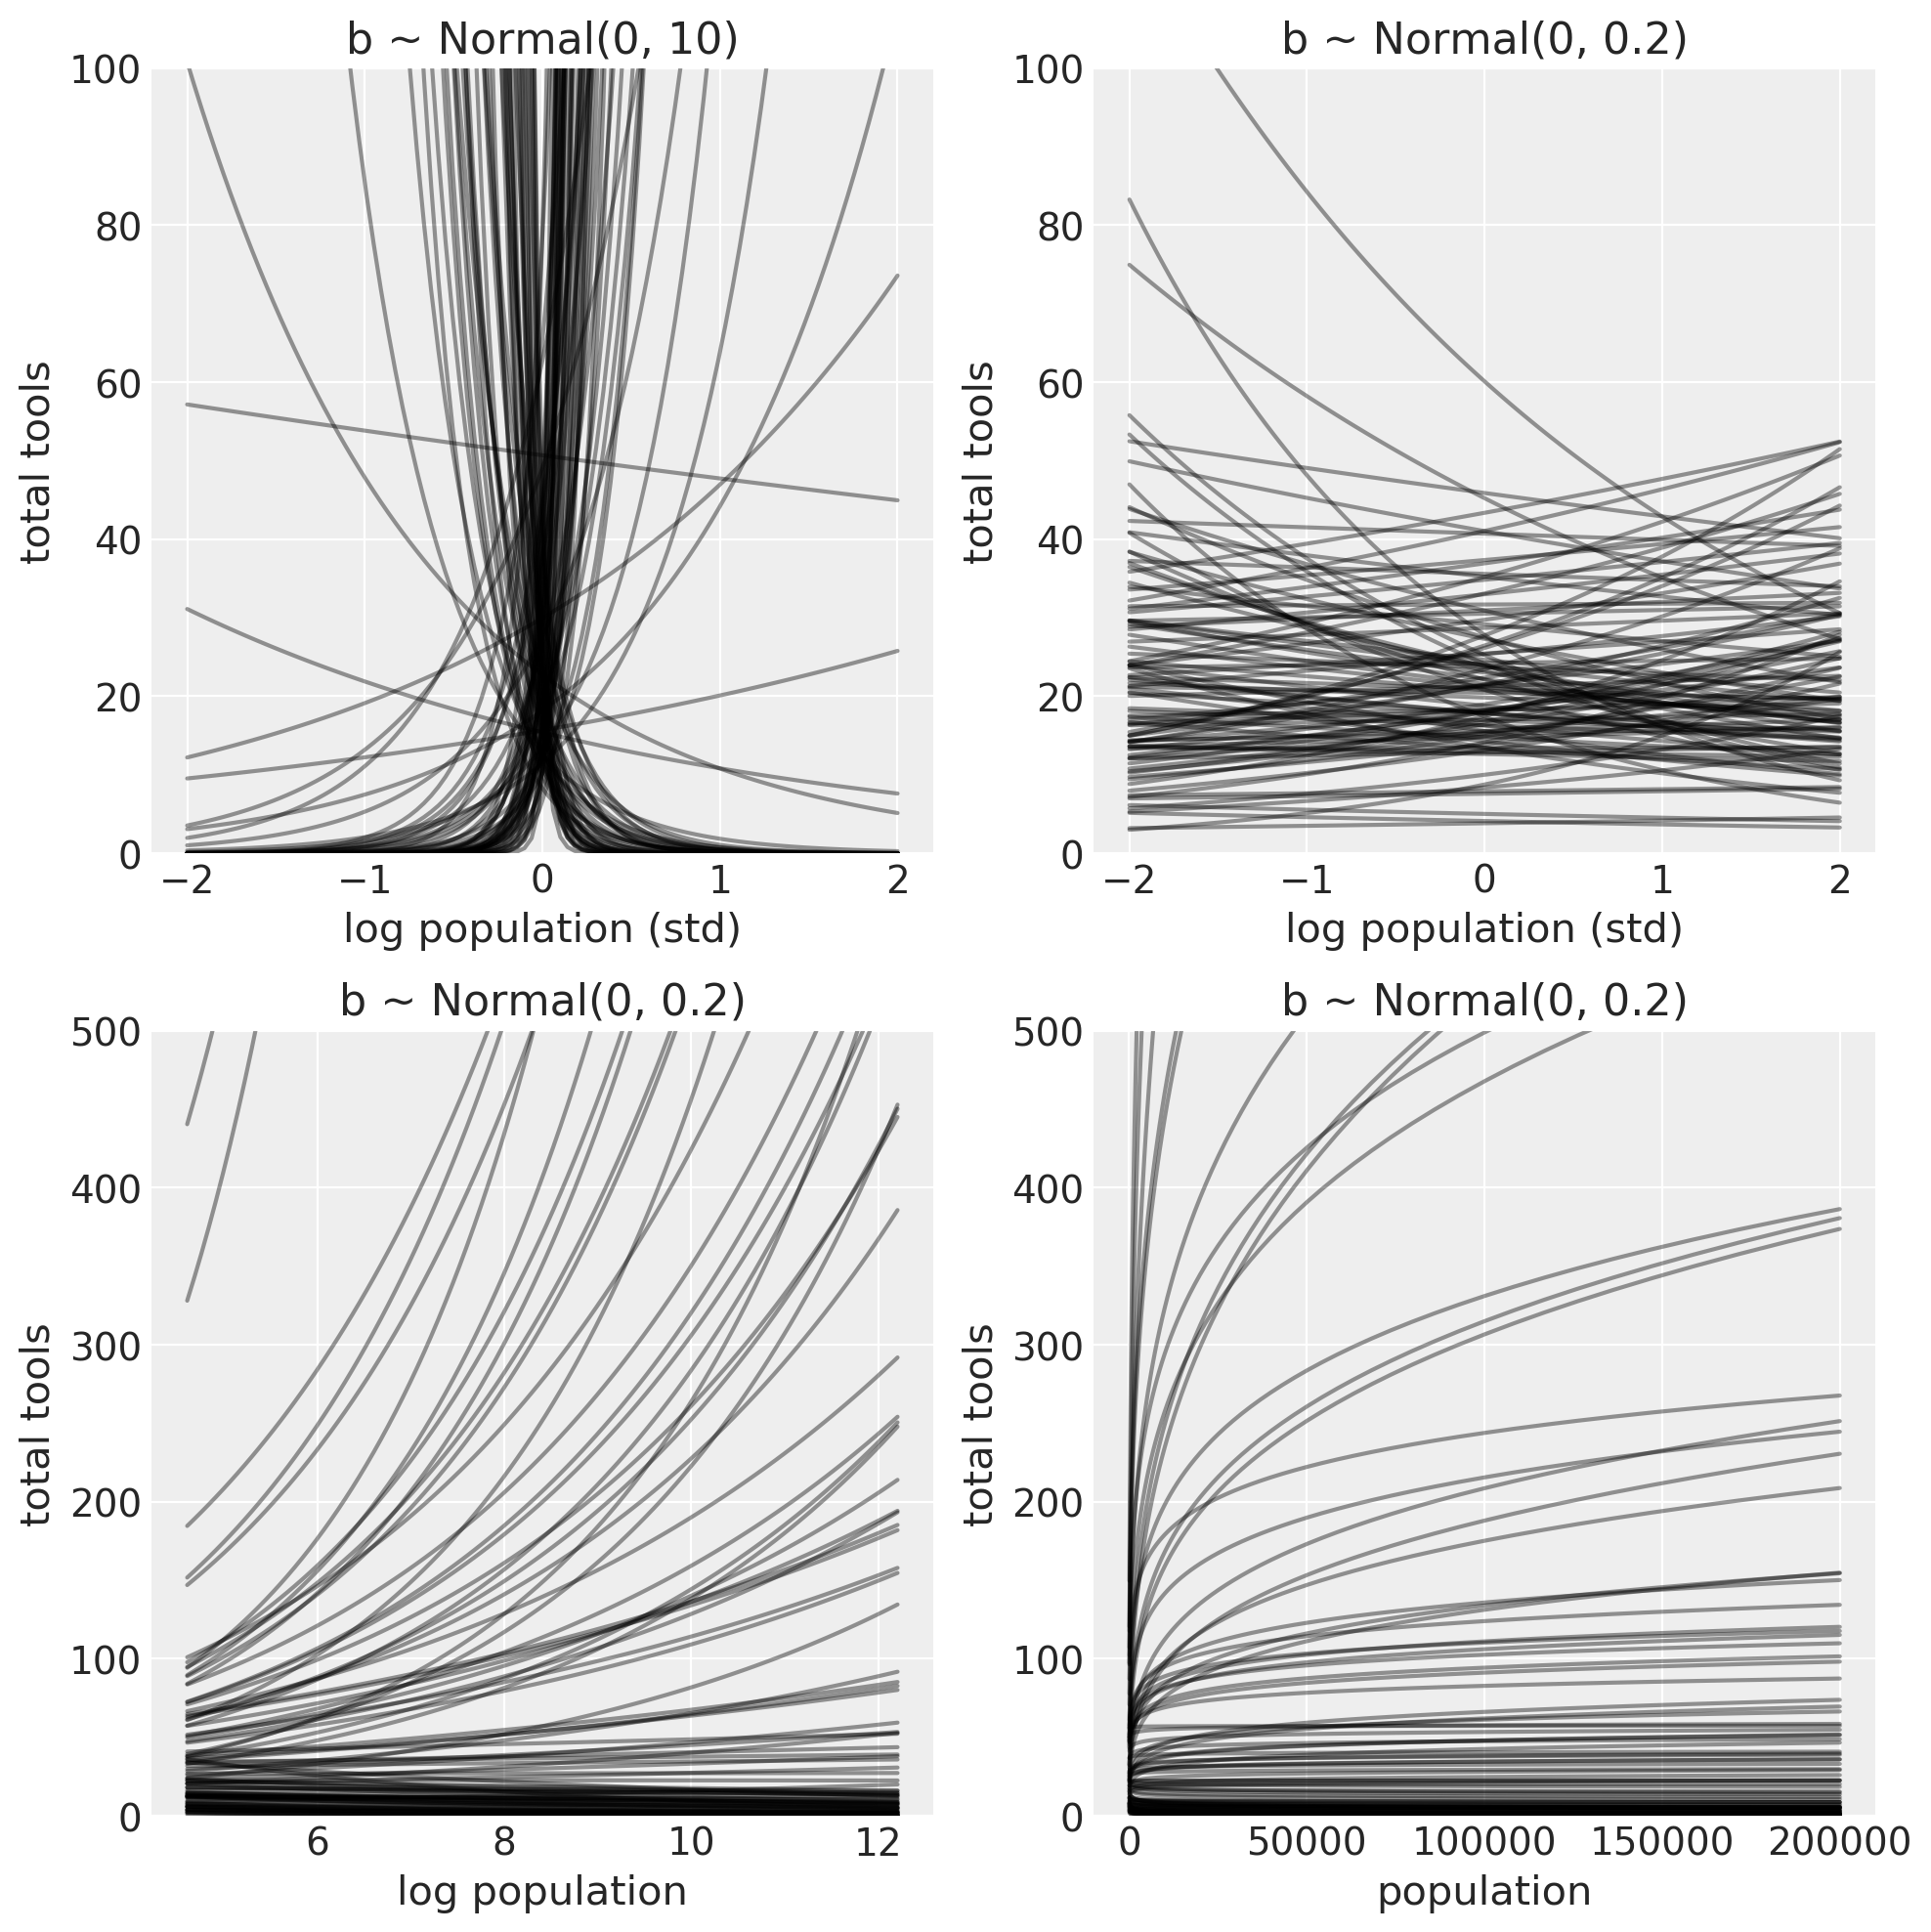

In [45]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
kline_prior_plot(b_prior="conventional", x_scale="stdz", ax=ax[0][0])
kline_prior_plot(b_prior="bespoke", x_scale="stdz", ax=ax[0][1])
kline_prior_plot(b_prior="bespoke", x_scale="log", ax=ax[1][0])
kline_prior_plot(x_scale="natural", ax=ax[1][1])
plt.tight_layout();

#### Code 11.45

In [46]:
# intercept only
with pm.Model() as m11_9:
    a = pm.Normal("a", 3.0, 0.5)
    T = pm.Poisson("total_tools", pm.math.exp(a), observed=dk.total_tools)
    trace_11_9 = pm.sample(tune=3000, random_seed=RANDOM_SEED)

# interaction model
with pm.Model() as m11_10:
    a = pm.Normal("a", 3.0, 0.5, shape=2)
    b = pm.Normal("b", 0.0, 0.2, shape=2)

    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = pm.math.exp(a[cid] + b[cid] * P_)

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools)
    trace_11_10 = pm.sample(tune=3000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8852990828409114, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 3 seconds.


#### Code 11.46

In [47]:
az.compare({"m11_9": trace_11_9, "m11_10": trace_11_10})

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:613: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:613: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-ro

rank      loo    p_loo    d_loo      weight       se      dse warning  \
m11_10    0 -43.0187  7.35019        0    0.997875  15.0965        0    True   
m11_9     1 -70.6275  7.96044  27.6088  0.00212461  5.99467  15.4197    True   

       loo_scale  
m11_10       log  
m11_9        log

In [48]:
# store pareto-k values for plot:
k = az.loo(trace_11_10, pointwise=True).pareto_k.values

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:613: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


#### Code 11.47 and 11.48

In [54]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns)

with m11_10:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])[
        "total_tools"
    ]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])[
        "total_tools"
    ]

lmu0, lmu1 = lam0.mean(0), lam1.mean(0)

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,


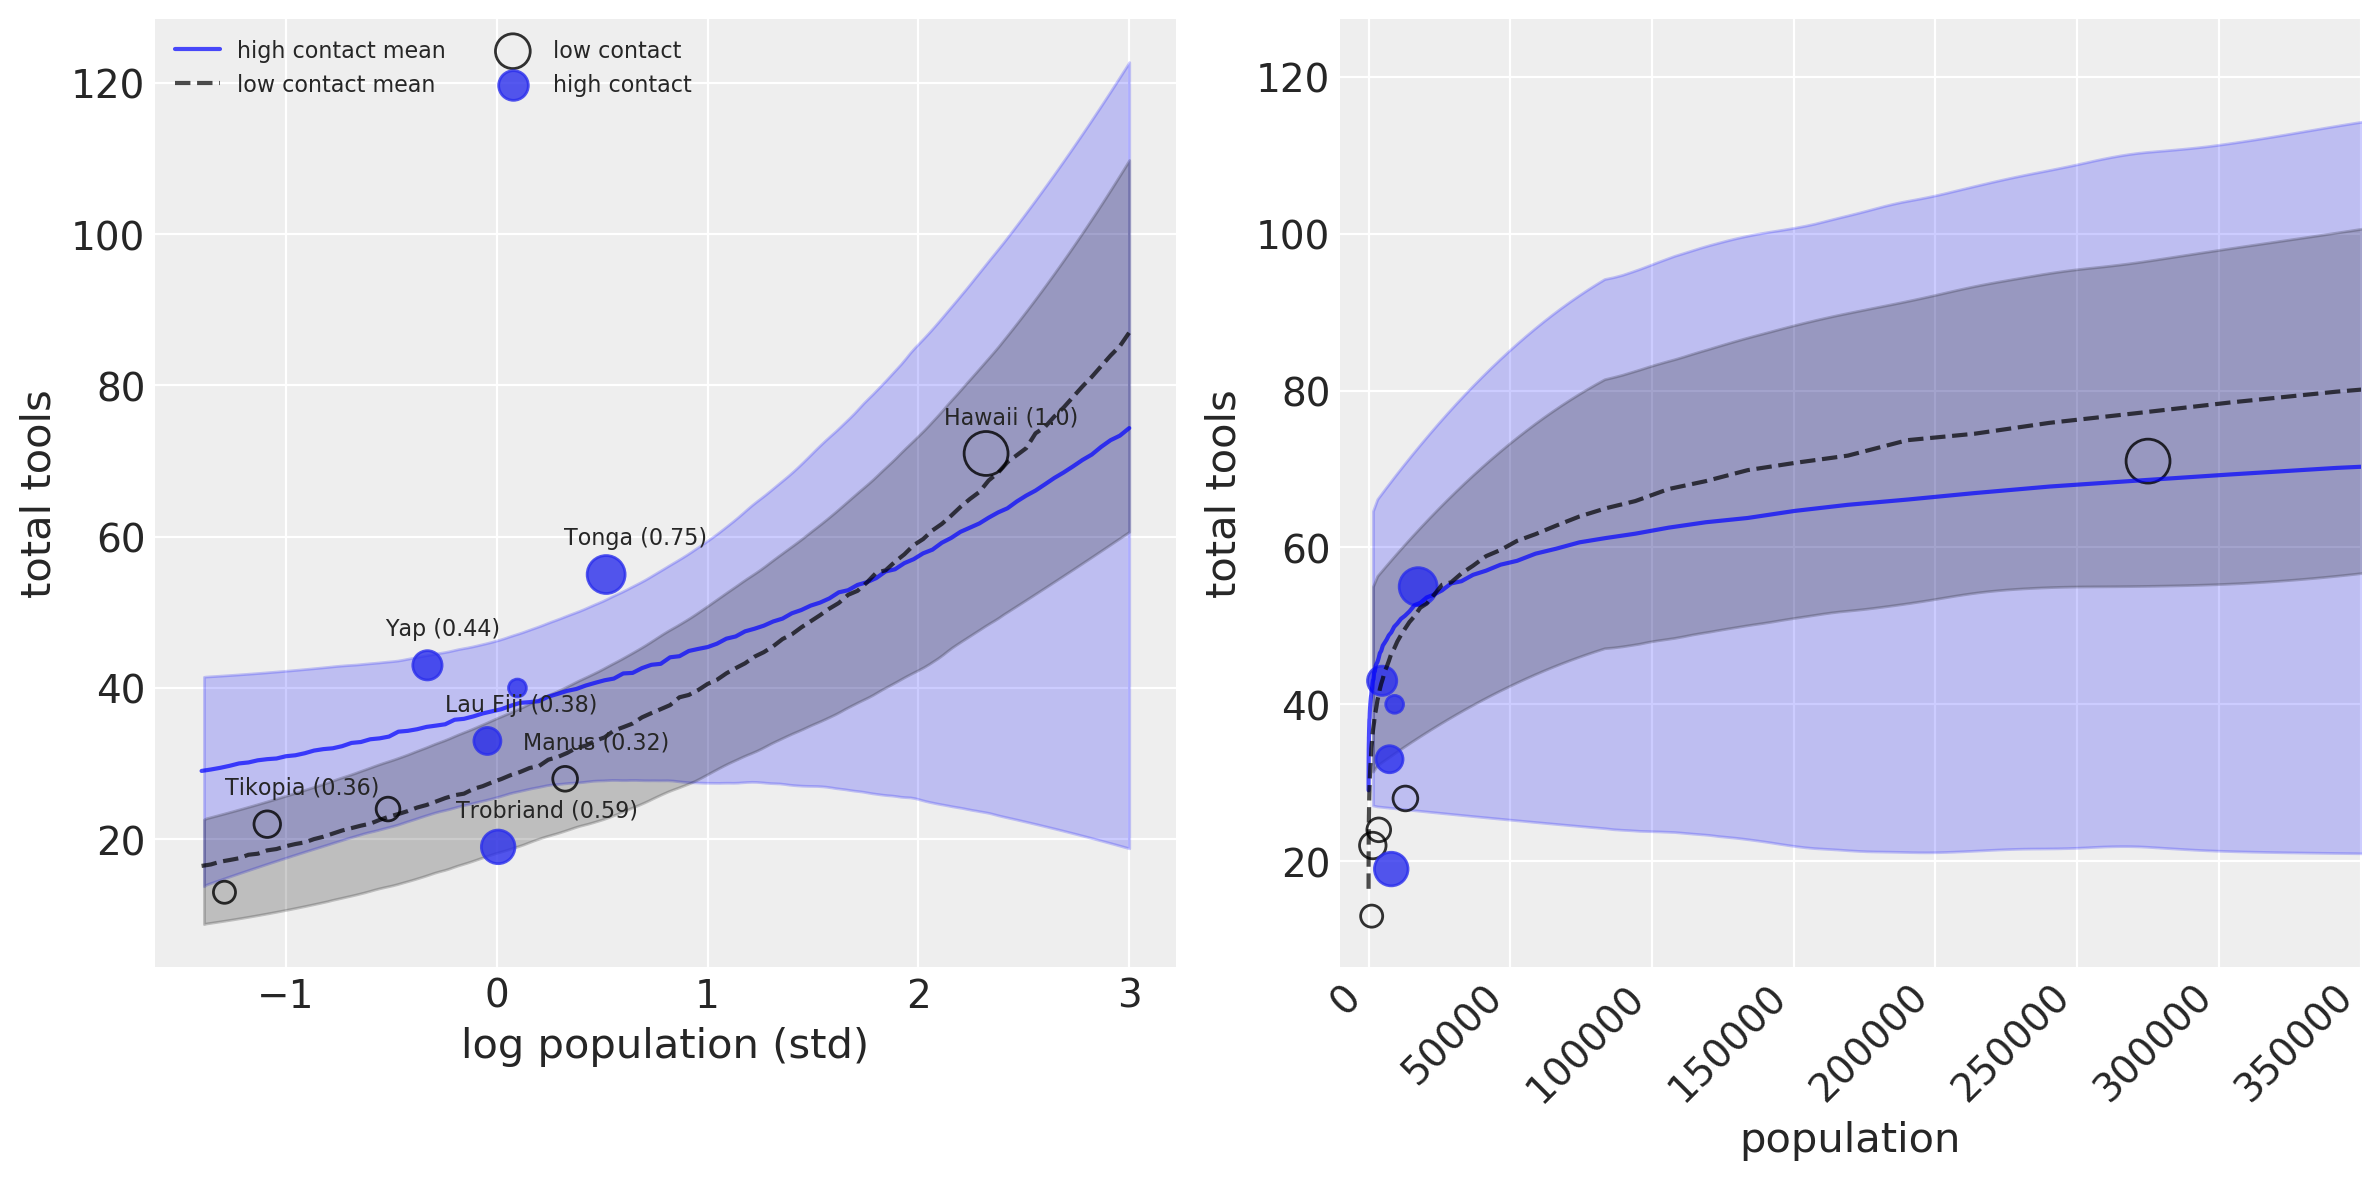

In [55]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

# scale point size to Pareto-k:
k /= k.max()
psize = 250 * k

# Plot on standardized log scale:

az.plot_hpd(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1, color="b", alpha=0.7, label="high contact mean")

az.plot_hpd(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0, "--", color="k", alpha=0.7, label="low contact mean")

# display names and k:
mask = k > 0.3
labels = dk.culture.values[mask]
for i, text in enumerate(labels):
    ax0.text(
        P[mask][i] - 0.2,
        dk.total_tools.values[mask][i] + 4,
        f"{text} ({np.round(k[mask][i], 2)})",
        fontsize=8,
    )

# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(
    P[index], dk.total_tools[index], s=psize[index], alpha=0.8, label="high contact"
)
ax0.set_xlabel("log population (std)")
ax0.set_ylabel("total tools")
ax0.legend(fontsize=8, ncol=2)

# Plot on natural scale:
# unstandardize and exponentiate values of standardized log pop:
P_seq = np.linspace(-5.0, 3.0, ns)
P_seq = np.exp(
    P_seq * np.log(dk.population.values).std() + np.log(dk.population.values).mean()
)

az.plot_hpd(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1, color="b", alpha=0.7)

az.plot_hpd(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools")
plt.tight_layout();

#### Code 11.49
The book doesn't pre-process the population data, but if you give them raw to PyMC3, the sampler will break: the scale of these data is too wide. However we can't just standardize the data, as we usually do. Why? Because some data points will then be negative, which doesn't play nice with the `b` exponent (try it if you don't trust me). But we'll do something similar: let's standardize the data, and then just add the absolute value of the minimum, and add yet again an epsilon -- this will ensure that our data stay positive and that the transformation will be easy to reverse when we want to plot on the natural scale:

In [15]:
P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0

And now we can run the model:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 24 seconds.


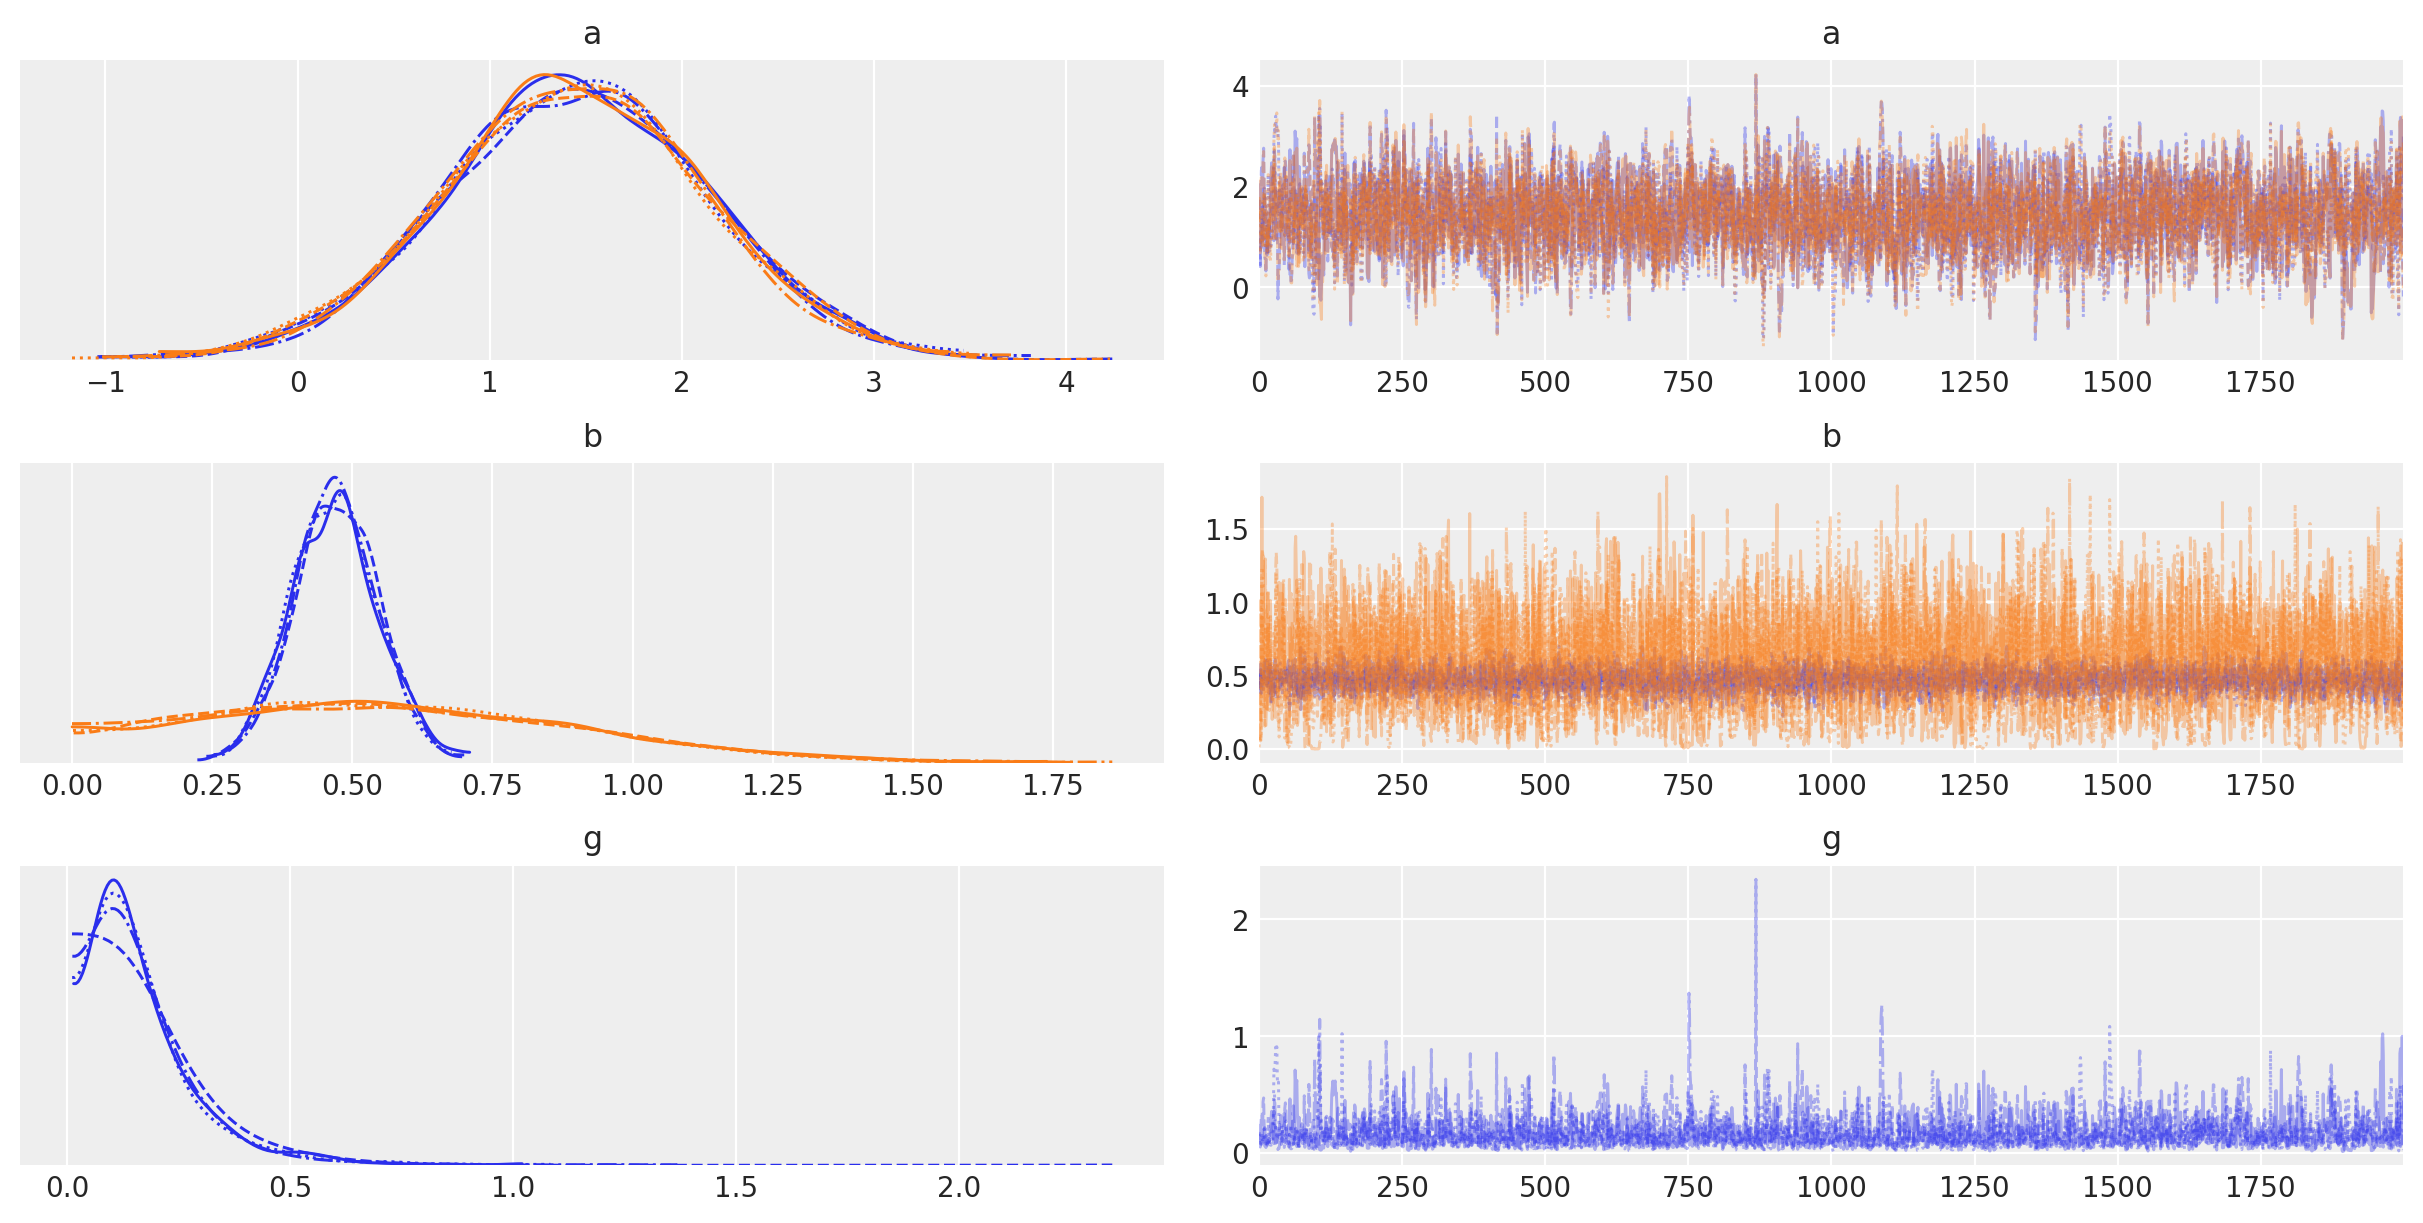

In [16]:
with pm.Model() as m11_11:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)

    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = (tt.exp(a[cid]) * P_ ** b[cid]) / g

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools)
    trace_11_11 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)
az.plot_trace(trace_11_11, compact=True);

#### Bonus: posterior predictive plot for scientific model

In [17]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4  # our little trick

with m11_11:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])[
        "total_tools"
    ]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])[
        "total_tools"
    ]

lmu0, lmu1 = lam0.mean(0), lam1.mean(0)

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (8000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (8000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (8000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (8000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,


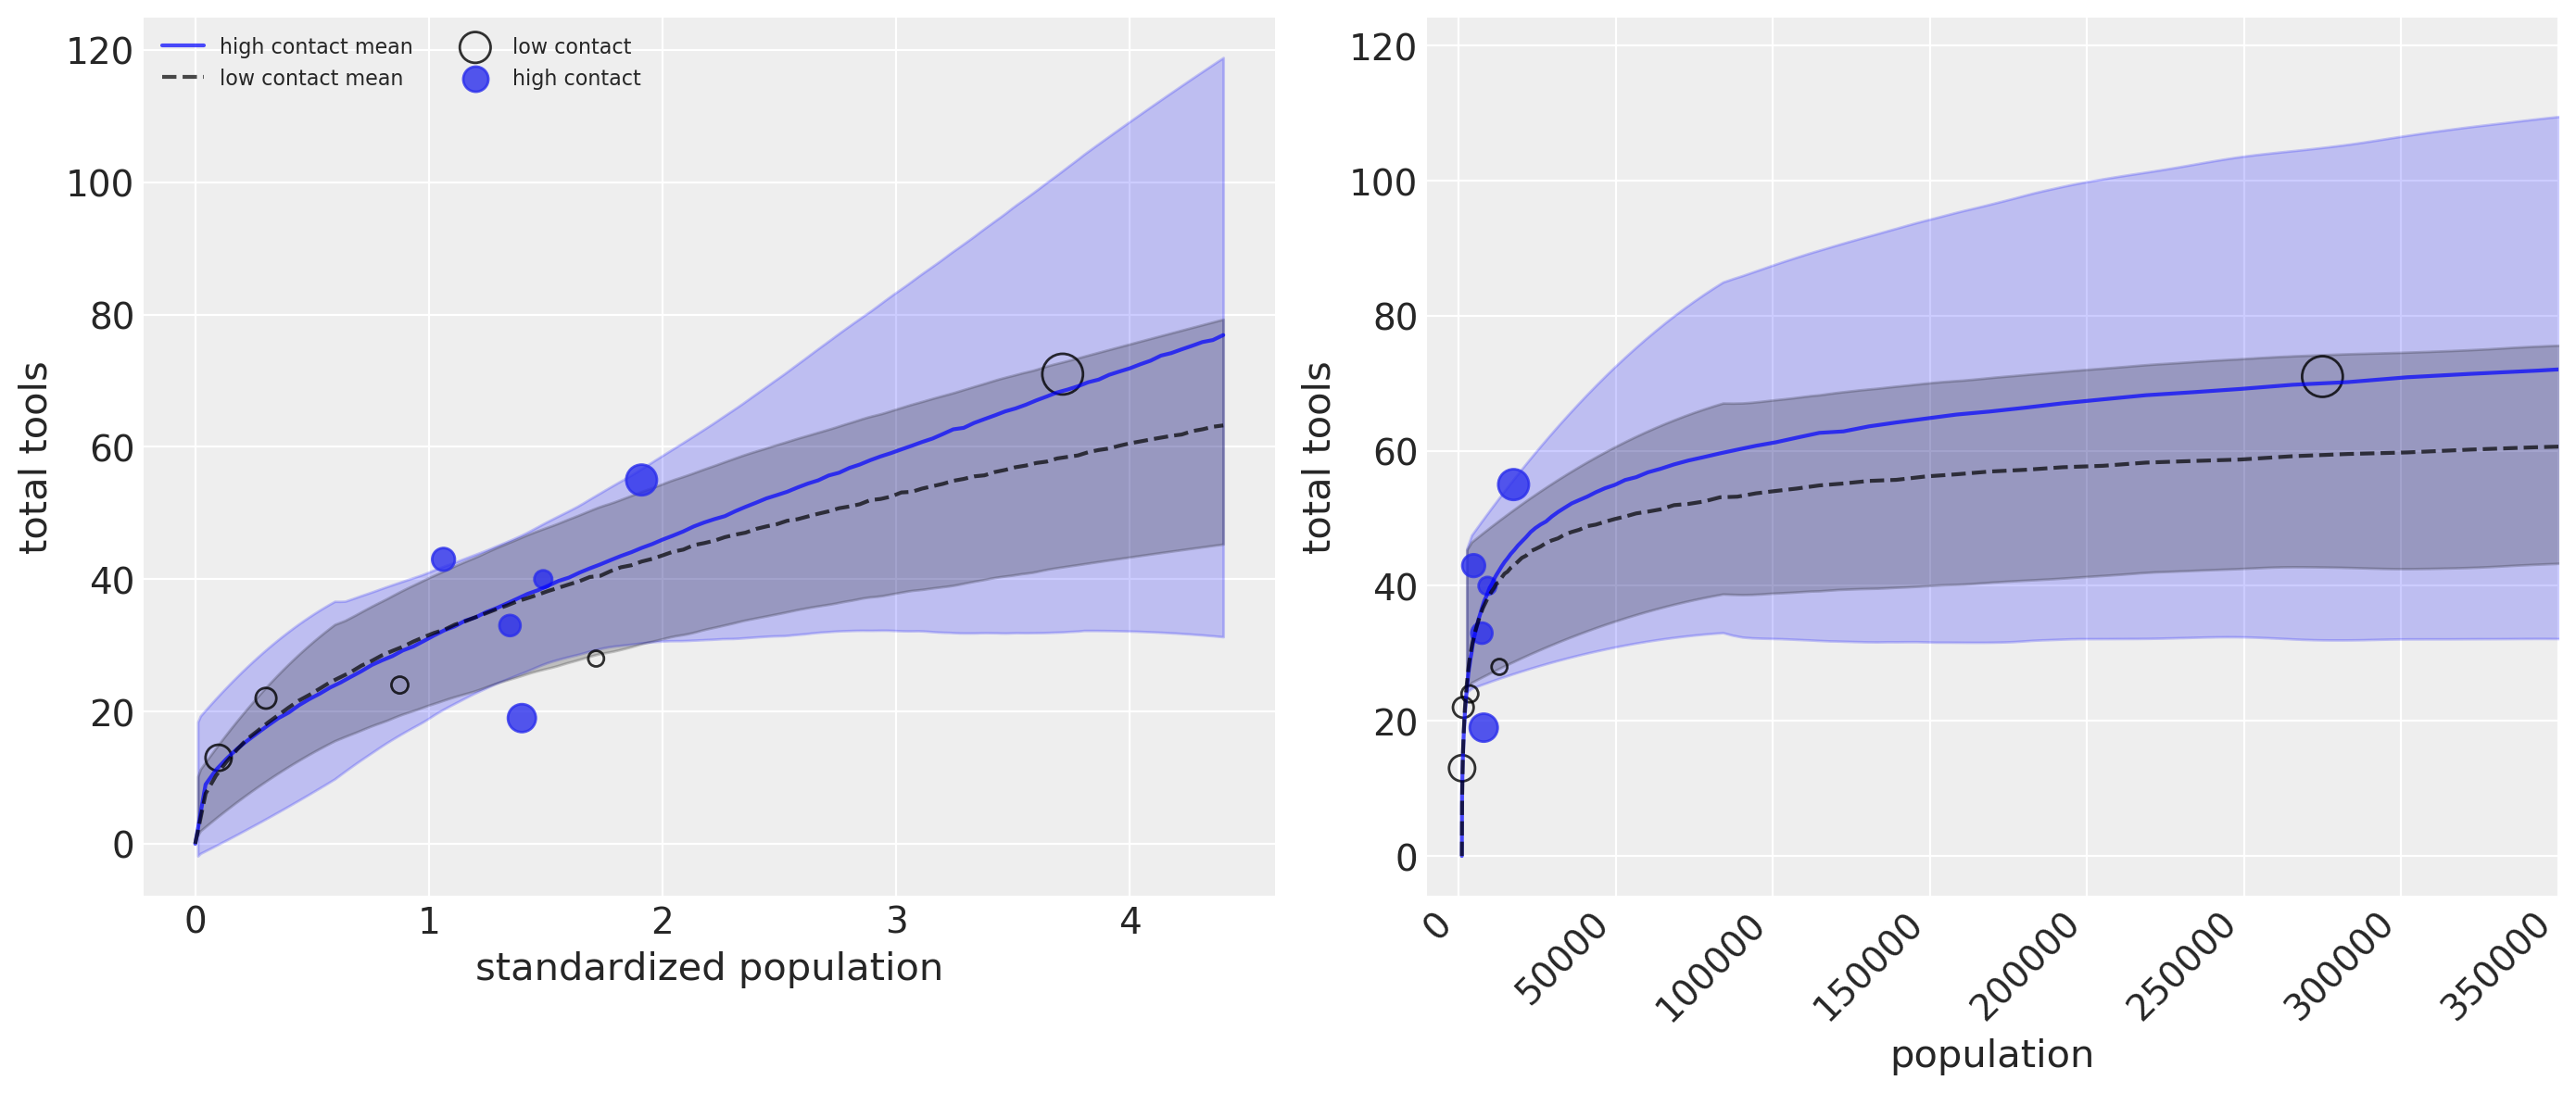

In [18]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))

# Plot on standardized log scale:
az.plot_hpd(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1, color="b", alpha=0.7, label="high contact mean")

az.plot_hpd(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0, "--", color="k", alpha=0.7, label="low contact mean")

# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(
    P[index], dk.total_tools[index], s=psize[index], alpha=0.8, label="high contact"
)
ax0.set_xlabel("standardized population")
ax0.set_ylabel("total tools")
ax0.legend(fontsize=8, ncol=2)

# Plot on natural scale:
# unstandardize our log pop sequence:
P_seq = np.exp(
    (P_seq - 1.4) * np.log(dk.population.values).std()
    + np.log(dk.population.values).mean()
)

az.plot_hpd(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1, color="b", alpha=0.7)

az.plot_hpd(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools")
plt.tight_layout();

#### Code 11.50

In [7]:
num_days = 30
y = np.random.poisson(1.5, num_days)
y

array([1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 3, 2, 2, 1, 0, 1, 0, 1, 1, 2,
       2, 2, 4, 1, 3, 3, 3, 3])

#### Code 11.51

In [8]:
num_weeks = 4
y_new = np.random.poisson(0.5 * 7, num_weeks)
y_new

array([2, 5, 3, 4])

#### Code 11.52

In [9]:
y_all = np.hstack([y, y_new])
exposure = np.hstack([np.repeat(1, 30), np.repeat(7, 4)]).astype("float")
monastery = np.hstack([np.repeat(0, 30), np.repeat(1, 4)])
y_all, exposure, monastery

(array([1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 3, 2, 2, 1, 0, 1, 0, 1, 1, 2,
        2, 2, 4, 1, 3, 3, 3, 3, 2, 5, 3, 4]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 7., 7., 7., 7.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]))

#### Code 11.53

In [10]:
# compute the offset:
log_days = np.log(exposure)

# fit the model:
with pm.Model() as m11_12:
    a = pm.Normal("a", 0.0, 1.0)
    b = pm.Normal("b", 0.0, 1.0)

    lam = pm.math.exp(log_days + a + b * monastery)

    obs = pm.Poisson("y", lam, observed=y_all)

    trace_11_12 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


#### Code 11.54

In [11]:
lambda_old = np.exp(trace_11_12["a"])
lambda_new = np.exp(trace_11_12["a"] + trace_11_12["b"])

az.summary(
    {"lambda_old": lambda_old, "lambda_new": lambda_new}, kind="stats", round_to=2
)

mean    sd  hpd_5.5%  hpd_94.5%
lambda_old  1.45  0.21      1.09       1.77
lambda_new  0.54  0.13      0.33       0.75

#### Code 11.55

In [64]:
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = np.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # score for each career, based on income
# converts scores to probabilities:
p = softmax(score)

# now simulate choice
# outcome career holds event type values, not counts
career = np.random.multinomial(1, p, size=N)
career = np.where(career == 1)[1]
career[:11], score, p

(array([2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2]),
 array([0.5, 1. , 2.5]),
 array([0.09962365, 0.16425163, 0.73612472]))

#### Code 11.56 and 11.57

To reproduce the book's results, we have to take the first career as pivot, not the last one. Why? Because the last career is by far the most probable (check out the `p` vector above), so if you take it as pivot, the `b` coefficient will be negative, because the other careers are a lot less probable anyway. Conversely, when we take the first career as the reference, increasing the income will indeed increase the expected probability of the corresponding career.

In [65]:
with pm.Model() as m11_13:
    a1, a2 = pm.Normal("a1", 0.0, 1.0), pm.Normal("a2", 0.0, 1.0)  # intercepts
    b = pm.Normal("b", 0.0, 0.5)  # association of income with choice

    s0 = 0.0
    s1 = a1 + b * income[1]
    s2 = a2 + b * income[2]
    s = pm.math.stack([s0, s1, s2])

    p_ = tt.nnet.softmax(s)
    career_obs = pm.Categorical("career", p=p_, observed=career)

    trace_11_13 = pm.sample(tune=2000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(trace_11_13, round_to=2)

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a2, a1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a1  0.09  0.38     -0.54       0.69       0.02     0.01    482.87  482.87   
a2  0.21  0.91     -1.23       1.64       0.04     0.03    467.96  467.96   
b   0.38  0.19      0.08       0.66       0.01     0.01    481.59  481.59   

    ess_bulk  ess_tail  r_hat  
a1    484.78    754.57   1.01  
a2    468.22    607.29   1.02  
b     481.98    630.62   1.02

#### Code 11.58

In [66]:
# set up logit scores:
s1_orig = trace_11_13["a1"] + trace_11_13["b"] * income[1]
s1_new = trace_11_13["a1"] + trace_11_13["b"] * income[1] * 2
s2 = trace_11_13["a2"] + trace_11_13["b"] * income[2]

pp_scores_orig = np.stack([np.zeros_like(s2), s1_orig, s2]).T
pp_scores_new = np.stack([np.zeros_like(s2), s1_new, s2]).T

# compute probabilities for original and counterfactual:
p_orig = softmax(pp_scores_orig, axis=1)
print(p_orig.shape)
p_new = softmax(pp_scores_new, axis=1)
print(p_new.shape)

# summarize
p_diff = p_new[:, 1] - p_orig[:, 1]
az.summary({"p_diff": p_diff}, kind="stats", round_to=2)

(4000, 3)
(4000, 3)


mean    sd  hpd_5.5%  hpd_94.5%
p_diff  0.15  0.08      0.01       0.27

#### Code 11.59

In [67]:
N = 500

# simulate family incomes for each individual
family_income = np.random.rand(N)

# assign a unique coefficient for each type of event
b = np.array([-2.0, 0.0, 2.0])

p = softmax(np.array([0.5, 1.0, 1.5])[:, None] + np.outer(b, family_income), axis=0).T

career = np.asarray([np.random.multinomial(1, pp) for pp in p])
career = np.where(career == 1)[1]
career[:11]

array([2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 0])

In [68]:
with pm.Model() as m11_14:
    a = pm.Normal("a", 0.0, 1.5, shape=2)  # intercepts
    b = pm.Normal("b", 0.0, 1.0, shape=2)  # coefficients on family income

    s0 = a[0] + b[0] * family_income
    s1 = a[1] + b[1] * family_income
    s2 = np.zeros(N)  # pivot
    s = pm.math.stack([s0, s1, s2]).T

    p_ = tt.nnet.softmax(s)
    career_obs = pm.Categorical("career", p=p_, observed=career)

    trace_11_14 = pm.sample(1000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)
az.summary(trace_11_14, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9 seconds.


mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a[0] -0.92  0.25     -1.30      -0.50       0.01     0.00   1856.95  1856.95   
a[1] -1.01  0.22     -1.35      -0.67       0.01     0.00   1248.26  1237.77   
b[0] -3.31  0.58     -4.22      -2.36       0.01     0.01   1905.08  1880.03   
b[1] -0.84  0.39     -1.44      -0.21       0.01     0.01   1558.64  1558.64   

      ess_bulk  ess_tail  r_hat  
a[0]   1846.76   2197.18    1.0  
a[1]   1248.58   1528.89    1.0  
b[0]   1910.31   2024.11    1.0  
b[1]   1562.63   1656.60    1.0

#### Code 11.60

In [69]:
d_ad = pd.read_csv("Data/UCBadmit.csv", sep=";")

#### Code 11.61

In [70]:
# binomial model of overall admission probability
with pm.Model() as m_binom:
    a = pm.Normal("a", 0, 1.5)
    p = pm.math.invlogit(a)

    admit = pm.Binomial("admit", p=p, n=d_ad.applications, observed=d_ad.admit)

    trace_binom = pm.sample(1000, tune=2000)

# Poisson model of overall admission and rejection rates
with pm.Model() as m_pois:
    a = pm.Normal("a", 0, 1.5, shape=2)
    lam = pm.math.exp(a)

    admit = pm.Poisson("admit", lam[0], observed=d_ad.admit)
    rej = pm.Poisson("rej", lam[1], observed=d_ad.reject)

    trace_pois = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


#### Code 11.62

In [71]:
m_binom = az.summary(trace_binom)
logistic(m_binom["mean"]).round(3)

a    0.388
Name: mean, dtype: float64

#### Code 11.63

In [72]:
m_pois = az.summary(trace_pois).round(2)
(
    np.exp(m_pois["mean"][0]) / (np.exp(m_pois["mean"][0]) + np.exp(m_pois["mean"][1]))
).round(3)

0.387

In [73]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy      1.18.1
arviz      0.7.0
pymc3      3.8
scipy      1.4.1
theano     1.0.4
pandas     0.25.3
matplotlib 3.1.3
last updated: Thu Apr 23 2020 

CPython 3.7.6
IPython 7.12.0
watermark 2.0.1
